In [ ]:
"""
Created on Mon Sep 16 11:35:32 2024

@author: Vviik
"""
# %% python -m cProfile myscript.py # Run this in the terminal to get timings for different function calls

import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mplcolors 
import time
import pickle
from scipy.optimize import fsolve
from scipy.optimize import broyden1
from scipy.optimize import differential_evolution
from scipy.linalg import eig
from scipy.linalg import inv

# CHOICES
figuresaving = True
cappedtemperature = True
constanttemperature = True
continuefromrun = False # are you continuing from an earlier run?
nosedifrac = 0 # 1e-2 # for how big fraction of the total time should sedimentation be halted. CHOICE 0 to 1. 
timechoice = False # should settime be the CHOICE
masschoice = True # or should Mfinal be the CHOICE
bothchoice = timechoice == masschoice # If timechoice == masschoice then both are CHOICES. (Both being False also works here.)
constantpebblerate = False # decide if the planet mass should grow linearly or exponentially
evendist = True  # decide initial distribution of volatiles to have a constant mass concentration throughout magma ocean
# decide initial distribution of volatiles to be concentrated in the layer closest to the core
innerdelta = not evendist
growthbool = True # decide if the planet should grow (met. and sil. accretion)
constantdensity = False  # decide to use the uncompressed silicate density throughout

number_of_boundaries = 50 # spatial discretization of volatile transport CHOICE
number_of_layers = number_of_boundaries-1
# cspread = 0.1  # Alt. 0. Allow 10 sigma inaccuracy. can't have too much spread if diffusion only transports to nearest layer
cspread = 0.25 # Alt. 1. Allow 4 sigma inaccuracy.
plotstepspacing = 1  # Every n timesteps plots are printed
# plot at most ___ plots. Redefines plotstepspacing if necessary
max_number_of_plots = 300 # CHOICE, 400 seems to be just too big for the cluster job memory limit? slurmstepd: error: StepId=49244262.batch exceeded memory limit (6679385088 > 6287261696), being killed
max_len_savefiles = 10*max_number_of_plots # CHOICE

number_of_structure_boundaries = int(1e4)
number_of_structure_iterations = 10
structureplotstepspacing = 1  # number_of_structure_timesteps
restructuringspacing = 20

#gasspacing = 1
gasspacing = restructuringspacing//2 

timecheckspacing = 100 # how often to check time elapsed

if constanttemperature:
    Tconst = 3000 # K, CHOICE.
M0 = 1e-4 # mass at which mass first starts accreting pebbles (units = Earth masses). 1e-2 I read somewhere(?), 1e-4 from Anders or maybe 1e-6 from Claudia. 
formationtime = 5e6 # time [yr] needed to form one Earth mass planet

massscaling = 0.02 # how many earth masses to start with. >0.3 seems very safe (deltaTad = negligible), >0.1 might be safe (temperature profile looks plausible).
stoppingmass = 0.6 # after how many earth masses do we stop accretion
settime = 5e5 # years of accretion to simulate

if not bothchoice:
    if masschoice: # Let the final mass decide how many years of accretion to simulate
        settime = formationtime*np.log(stoppingmass/massscaling)/np.log(1/M0)
    elif timechoice: # Let the years of accretion to simulate decide what the stopping mass should be
        stoppingmass = massscaling*np.exp(settime/formationtime*np.log(1/M0))
print(str(sys.argv[0])+'. Starting mass: '+str(massscaling)+'. M0: '+"{:.2e}".format(M0)+'. Mfinal: '+str(stoppingmass)+'. Tfinal: '+"{:.2e}".format(settime)+'. Nosedifrac: '+"{:.2e}".format(nosedifrac))

# -------------------------------General functions-----------------------------
def delta(array): # calculates the forward difference to the next element in array. returns array with one less element than input array
    return array[1:]-array[:-1]

# calculates the mean value between subsequent elements in array. returns array with one less element than input array
def centeraveraging(array):
    return (array[1:]+array[:-1])/2

# initializing
volatiles = np.array(['hydrogen', 'carbon', 'nitrogen'])
gasvolatiles = np.array(['H2O', 'CO2', 'N2'])
extragasvolatiles = np.array(['H2', 'CO']) # alternate (reduced) speciation of gaseous volatile-bearing species
fullgasvolatiles = np.concatenate((gasvolatiles, extragasvolatiles))
vcolors = np.array(['c', 'r', 'g'])
fullvcolors = np.concatenate((vcolors, vcolors[:-1]))
irange = range(len(volatiles))
# volatiles = np.array(['hydrogen', 'carbon', 'nitrogen', 'oxygen'])
# vcolors = np.array(['c', 'r', 'g', 'b'])
# irange = range(len(volatiles))

pi = np.pi
sqrtpi = np.sqrt(np.pi)
sqrt2 = np.sqrt(2)

# conversions
GPaconversion = 1.0041778e-15  # conversion to GPa from Pg, km, year units
densityconversion = 1e3  # converts from Pg km-3 to kg m-3
secondsperyear = 31556926  # 31 556 926 seconds per year
Cpconv = 995839577 # converts specific heat capacity from units of J kg-1 K-1 to km2 yr-2 K-1
GPatobar = 1e4 # converts from GPa to bar
GPatokbar = GPatobar/1e3 # converts from GPa to kbar

# units: years, km, Pg (Petagram)
G = 66465320.9  # gravitational constant, km3 Pg-1 yr-2
sigmaBoltzmann = 1781.83355 # Boltzmann constant sigma = 5.67*1e-8 W/m^2 K^-4 converted to Petagram year^-3 K^-4
kB = 1.37490492e-26 # kB Boltzmann constant = 1.37490492e-23 J/K in Pg km2 yr-2 K-1

vmet = 1e-3*secondsperyear  # 1 m/s in km yr-1, falling speed of metal blobs
silicatedensity = 3.4 # Pg km-3
# 5.7 # Pg km-3, Earth's Core chapter by David Loper. PLACEHOLDER
coremetaldensity = 10.48
earthmass = 5.9712e12  # Earth's mass in Pg
venusmass = 4.86732e12 # Venus' mass in Pg
mproton = 1.67262192e-39 # proton mass in Pg

Lsun = 1.20862995e31 # solar luminosity. 3.84600e26 J/s in Pg km2 yr-3
AU = 149597871 # 1 AU in km  
a0 = 1.6*AU # CHOICE of starting point. 
a = np.copy(a0) # PLACEHOLDER. Use proper a(M(t)) growth track. 

# Calculate initial pebble mass accretion rate
if constantpebblerate:
    pebblerate0 = 1*earthmass/formationtime # Pg yr-1, PLACEHOLDER VALUE, x order(s) of magnitude less than what is required to form a 1 Earth mass planet over 5 Myr.
else:
    tau = formationtime/np.log(1/M0)
    pebblerate0 = massscaling*earthmass/tau # Pg yr-1

pebblemetalfrac = 0.3  # mass fraction of metal (iron) in accreted pebbles. Mass fraction here means met/(met+sil) PLACEHOLDER
coremassfraction = pebblemetalfrac # consistent with formation
# coreradiusfraction = 1/(1+coremetaldensity/silicatedensity*(1/coremassfraction-1))**(1/3) # 3480/6371 in Earth's Core chapter by David Loper. PLACEHOLDER

# Set planet mass, initial uncompressed radius is determined from CHOICE of planet mass
protomass = massscaling*earthmass
mc0 = coremassfraction*protomass # fraction of the total protoplanetary mass that is composed of the core
rcore0 = (3*mc0/(4*pi*coremetaldensity))**(1/3)
rsurf0 = ((protomass-mc0)/(4*pi*silicatedensity/3)+rcore0**3)**(1/3) # km, initial planet radius
        
# compression and expansion values
alpha0 = 3e-5  # volumetric thermal expansion coefficient, K-1
heatconductivity = 4*31425635.8 # base heat conductivity in AnatomyI, 4 W m-1 K-1 in Pg km year-3 K-1
K0 = 200  # bulk modulus, GPa
K0prime = 4  # bulk modulus derivative w.r.t pressure
# silicate melt heat capacity at constant pressure (1200 J kg-1 K-1), km2 yr-2 K-1
Cpsil = Cpconv*1200
gsurf0 = G*protomass/rsurf0**2  # gravity at surface

# atmosphere
Mearthatm = 5.15e6  # Pg, current mass of Earth's atmosphere
Mvenusatm = 4.8e8 # Pg
atmexponent = 0 # PLACEHOLDER CHOICE. what exponent in scaling law for guess of initial atmosphere
Matmlow = Mearthatm*(protomass/earthmass)**atmexponent # Pg, mass of the atmosphere of the protoplanet modelled
Matmhigh = Mvenusatm*(protomass/venusmass)**atmexponent
Matmguess = Matmhigh # CHOICE, should it be? 
opacitypho = 1e-3*1e6  # (gray) Rosseland mean opacity from Badescu2010. 1e6 factor for conversion from m^2 kg^-1 to km^2 Pg^-1, PLACEHOLDER
def opacityfunc(p, T): # scaling from Rogers2024. pressure input in GPa
    pinbar = p*GPatobar
    alpha, beta = 0.68, 0.45
    kappa = 1.29e-2*1e6*(pinbar/1)**alpha*(1/1000)**beta # 1e5 factor for conversion from cm^2 g^-1 to km^2 Pg^-1    
    return kappa

monoatomicgamma = 5/3 # 1.666666
diatomicgamma = 7/5 # 1.4
triatomicgamma = 8/6 # 1.3333
lowgamma = 1.25 # higher temperatures --> lower Cp, lower Cp/Cv. 
envgamma = triatomicgamma # CHOICE. adiabatic gamma from the top of the outgassed atmosphere (bottom of the envelope) up to the RCB. 

# molar masses of main volatile gas species
amuH2O = 18 
amuCO2 = 44 
amuN2 = 28 
amui = np.array([amuH2O, amuCO2, amuN2])

# molar masses of reduced volatile gas species
amuH2 = 2
amuCO = 28
amuiextra = np.array([amuH2, amuCO]) 

amuifull = np.concatenate((amui, amuiextra))

# molar masses of the atoms
amuC = 12
amuN = 14
amuatoms = np.array([1, amuC, amuN])

# molar masses of melt species
amuOH = 17
amuCO3 = 60
amuNH = 15
amuNH2 = 16
amuNH3 = 17


def molefraction(w, amu): # calculates the mole fraction of each species using the weight fraction (or mass) and atomic mass of each species
    return np.array([(w[i]/amu[i])/(np.sum(w/amu)) for i in range(len(w))])

def weightfraction(x, amu): # calculates the weight fraction of each species using the mole fraction and atomic mass of each species
    return np.array([(x[i]*amu[i])/(np.sum(x*amu)) for i in range(len(x))])

# melt properties. LEGACY EXCEPT FOR NBOperT and deltaIW?

deltaIW = 0 # log scale of difference from oxygen fugacity produced by IW buffer at surface pT.
deltaIWmagmaocean = -2 # log scale of difference from oxygen fugacity produced by IW buffer in magma ocean. 

melt = 'enstatite'
NBOperT = 2 # CHOICE
if melt=='enstatite': # MgSiO3 simplified. Same resulting product if considering Mg2Si2O6 instead since amuMelt is doubled and Siperformula becomes is halved. 
    amuMelt = 100 
    Tperformula = 1 # one Mg in MgSiO3
    NBOperO = NBOperT/3 # three O per one Mg
else: # forsterite, Mg2SiO4
    amuMelt = 140
    Tperformula = 2 # two Mg in MgSiO3
    NBOperO = NBOperT/2 # four O per two Mg

# number of volatile-bearing products per volatile reactant
alphaH2O = 2 # H2O(gas) + O(melt) = 2 OH(melt) e.g. Stolper1982. 
alphaCO2 = 1 # CO2(gas) + O(melt) = CO3(melt) e.g. Ortenzi2020, Fegley2020. Or more accurately M2SiO4(melt)+CO2(g) = MCO3(melt) + MSiO3(melt) e.g. Spera1980. 
alphaN2chem = 2 # N2(gas)+_*H2O(gas)+(3-_)*O(melt) = 2 NH_ + 3/2 O(gas) e.g. Grewal2020.
alphaN2phys = 1 # N2(gas) = N2(melt)  
# alphai = np.array([alphaH2O, alphaCO2, alphaN2]) 
alphai = np.array([[alphaH2O, 1],[alphaCO2, 1],[alphaN2chem, alphaN2phys]]) # 1 for dummy variables where Ki = 0. 

# initial total mass of volatiles, CHOICE
MH2Otot0 = 2e3*1e-6*earthmass # Fig. 11, AnatomyIII.
MCtot0 = 600*1e-6*earthmass # 600 ppmw total estimated from Anders2021 or AnatomyIII. 27 ppmw of total planet mass of Venus lies in atmosphere (google) 
MNtot0 = 10**0.5*1e-6*earthmass # mass fraction of total planet mass of Venus in atmosphere, from same figure in AnatomyIII
Mitot0 = np.array([MH2Otot0, MCtot0, MNtot0])

XFeO = 0.1 # PLACEHOLDER. NEEDED FOR PNfunc and CO2 solubility. GET CORRECT CALCULATION OF THIS. 
XO = 0.08 # 8wt% from Fischer2020 upper limit of core currently. 
XS = 0


/software/astro/anaconda/anaconda3-2021.05/lib/python3.8/site-packages/ipykernel_launcher.py. Starting mass: 0.02. M0: 1.00e-04. Mfinal: 0.6. Tfinal: 1.85e+06. Nosedifrac: 0.00e+00


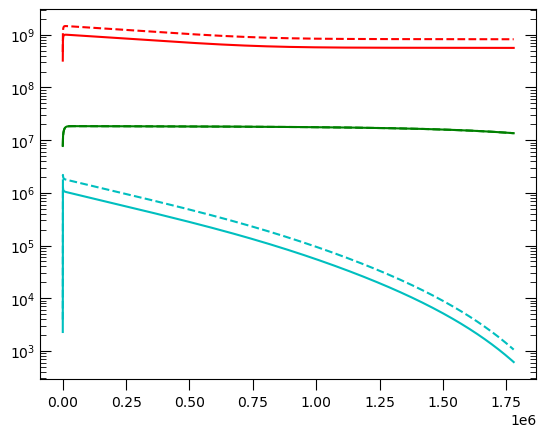

In [ ]:
# LOADER 
timearray = np.loadtxt('time.out', delimiter=',')
simulationtimearray = np.loadtxt('simulationtime.out') # real time [s] since beginning of simulation, one number per time step
surfcondtimearray = np.loadtxt('Surf.out', delimiter=',') # rsurf, psurf, Tsurf order
cmbcondtimearray = np.loadtxt('CMB.out', delimiter=',') # rhocmb, pcmb, Tcmb orde
Miatmtimearray = np.loadtxt('Misurf.out', delimiter=',') # Miatm for each time step
Miatmextratimearray = np.loadtxt('Misurfextra.out', delimiter=',') # Miatmextra for each time step
Micoretimearray = np.loadtxt('Micore.out', delimiter=',') # Micore for each time step
Mctimearray = np.loadtxt('Mcore.out', delimiter=',') # Mcore for each time step
Mmagmatimearray = np.loadtxt('Mmagma.out', delimiter=',') # mass of magma ocean for each time step
protomasstimearray = np.loadtxt('protomass.out', delimiter=',') # protomass for each time step

timeplotarray = np.loadtxt('timeplot.out', delimiter=',') # file that stores time in years at each time step where plots are produced or 1D variables are recorded
rkfromfile = np.loadtxt('rk.out', delimiter=',') # rows are layer boundaries for a given t (corresponding to timeplot.out)
pressurefromfile = np.loadtxt('pressure.out', delimiter=',') # rows are pressure profile for a given t (corresponding to timeplot.out)
temperaturefromfile = np.loadtxt('temperature.out', delimiter=',') # -||- but temperature profile
densityfromfile = np.loadtxt('density.out', delimiter=',') # -||- but density profile
Mtotfromfile = np.loadtxt('Mtot.out', delimiter=',') # -||- but total mass in each layer
Mvolfromfile = np.stack([np.loadtxt('M'+volatiles[i]+'.out', delimiter=',') for i in irange], axis=1) # special care necessary due to being 3d array
Pvolfromfile = np.stack([np.loadtxt('P'+volatiles[i]+'.out', delimiter=',') for i in irange], axis=1) # partition coefficient for each volatile for each time step. 3d array.

rsurf_evo, psurf_evo, Tsurf_evo = surfcondtimearray
rhocmb_evo, pcmb_evo, Tcmb_evo = cmbcondtimearray

# Calculating total volatile mass in magma ocean
Mimagma = np.sum(Mvolfromfile, axis=2)

# Miatmfull calculation
Miatmsumtimearray = Miatmtimearray+np.vstack((Miatmextratimearray, np.zeros(len(timearray))))
Miatmequivsumtimearray = Miatmtimearray+np.vstack((np.array([M*amui[:2]/amuiextra for M in Miatmextratimearray.transpose()]).transpose(), np.zeros(len(timearray))))
Miatmfulltimearray = np.concatenate((Miatmtimearray, Miatmextratimearray))


# Interpolating to more sparse values
protomasstimeplotarray = np.interp(timeplotarray, timearray, protomasstimearray)


In [140]:
print(timearray.shape)
print(simulationtimearray.shape)
print(surfcondtimearray.shape)
print(cmbcondtimearray.shape)
print(Miatmtimearray.shape)
print(Miatmextratimearray.shape)
print(Miatmsumtimearray.shape)
print(Miatmfulltimearray.shape)
print(Micoretimearray.shape)
print(Mctimearray.shape)
print(Mmagmatimearray.shape)
print(protomasstimearray.shape)

print(timeplotarray.shape)
print(rkfromfile.shape)
print(pressurefromfile.shape)
print(temperaturefromfile.shape)
print(densityfromfile.shape)
print(Mtotfromfile.shape)
print(Mvolfromfile.shape)
print(protomasstimeplotarray.shape)


(2815,)
(2815,)
(3, 2815)
(3, 2815)
(3, 2815)
(2, 2815)
(3, 2815)
(5, 2815)
(3, 2815)
(2815,)
(2815,)
(2815,)
(282,)
(282, 49)
(282, 49)
(282, 49)
(282, 49)
(282, 49)
(282, 3, 49)
(282,)


In [141]:
# Plot from index _startind to _stopind. MANUAL CHOICE.Useful to see past starting weirdness
truncateplots = True

if truncateplots:
    shortstartind = 14 # Manual selection. Slightly less than np.argmax(psurf_evo). (Early overshooting of outgassed atm.)
    shortstopind = -1
    longstartind = 140
    longstopind = -1
else:
    shortstartind = 0
    shortstopind = -1
    longstartind = 0
    longstopind = -1


In [142]:
# Plotting params
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = False
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4

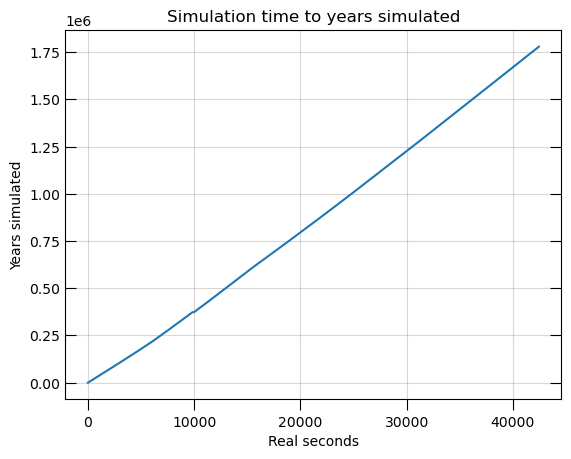

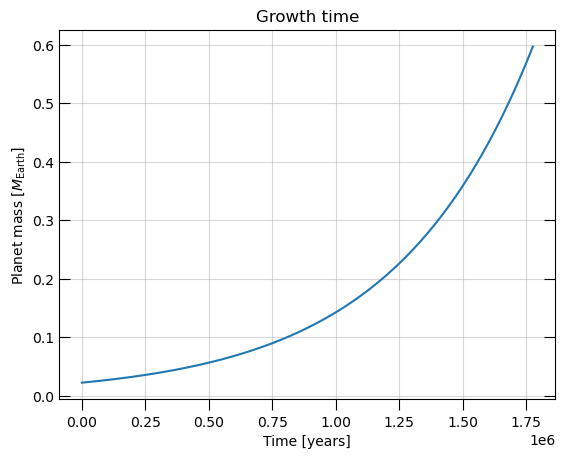

In [143]:
plt.figure()
plt.plot(simulationtimearray, timearray)
plt.title('Simulation time to years simulated')
plt.ylabel('Years simulated')
plt.xlabel('Real seconds')
plt.grid(alpha=0.5)

plt.figure()
plt.plot(timeplotarray, protomasstimeplotarray/earthmass)
plt.title('Growth time')
plt.ylabel('Planet mass '+r'$[M_\mathrm{Earth}]$')
plt.xlabel('Time [years]')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,3))
plt.grid(alpha=0.5)



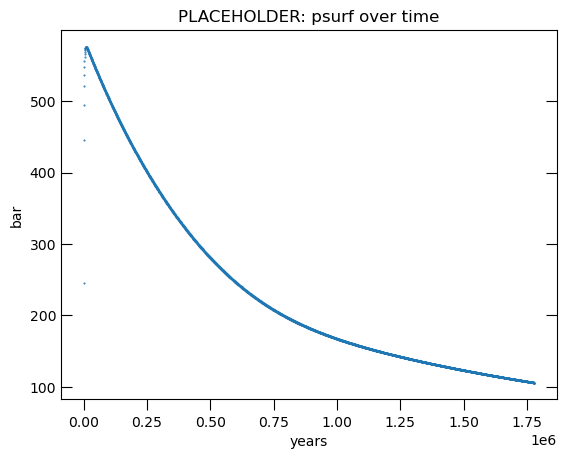

In [144]:
plt.figure()
plt.title('PLACEHOLDER: psurf over time')
plt.xlabel('years')
plt.ylabel('bar')
plt.plot(timearray, psurf_evo*GPatobar,'.', markersize=1)


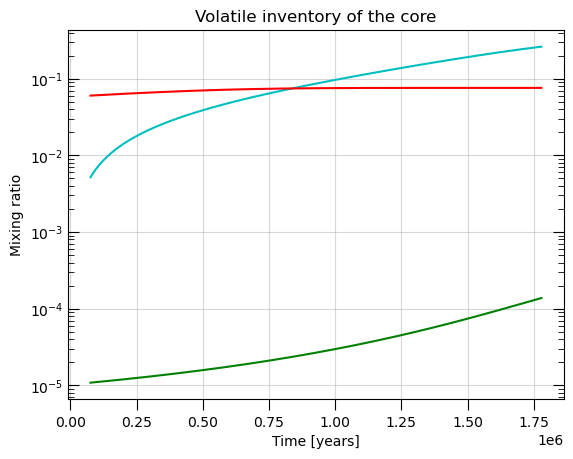

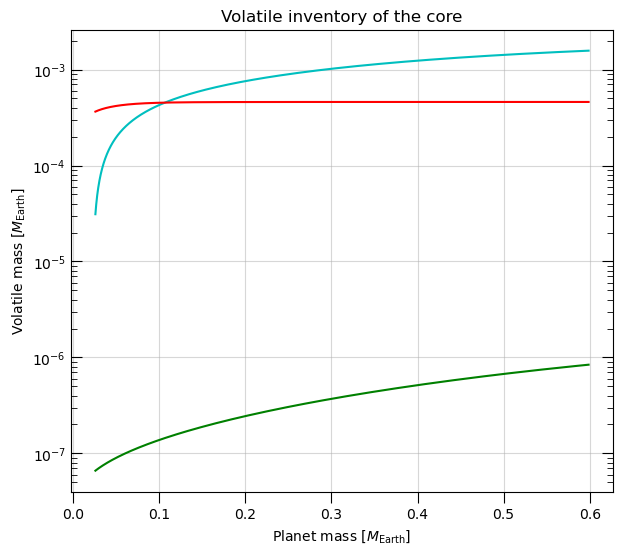

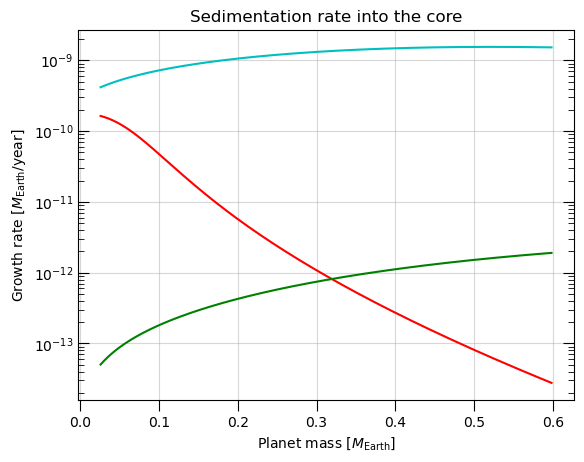

In [145]:
# Xicore vs. time PLACEHOLDER.
plt.figure()
for i in irange:
    plt.semilogy(timearray[longstartind:longstopind], Micoretimearray[i][longstartind:longstopind]/Mctimearray[i], color=vcolors[i])
    plt.title('Volatile inventory of the core')
    plt.ylabel('Mixing ratio')
    plt.xlabel('Time [years]')
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,3))
    plt.grid(alpha=0.5)

# Micore vs. protomass
plt.figure(figsize=(7,6))
for i in irange:
    plt.semilogy(protomasstimearray[longstartind:longstopind]/earthmass, Micoretimearray[i][longstartind:longstopind]/earthmass, color=vcolors[i])
    plt.title('Volatile inventory of the core')
    plt.ylabel('Volatile mass '+r'$[M_\mathrm{Earth}$]')
    plt.xlabel('Planet mass '+r'$[M_\mathrm{Earth}$]')
    plt.grid(alpha=0.5)

# dMicore/dt vs. protomass
plt.figure()
for i in irange:
    sedrate = (delta(Miatmtimearray[i][longstartind:longstopind])/delta(timearray[longstartind:longstopind]))/earthmass
    plt.semilogy(centeraveraging(protomasstimearray[longstartind:longstopind])/earthmass, (delta(Micoretimearray[i][longstartind:longstopind])/delta(timearray[longstartind:longstopind]))/earthmass, color=vcolors[i])
    plt.title('Sedimentation rate into the core')
    plt.ylabel('Growth rate '+r'$[M_\mathrm{Earth}/\mathrm{year}]$')
    plt.xlabel('Planet mass ' + r'$[M_\mathrm{Earth}$]')
    # plt.gca().set_xlim(xmin=0.024)
    plt.grid(alpha=0.5)

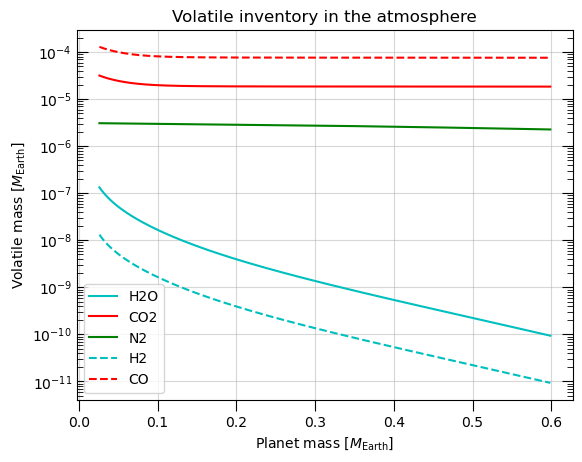

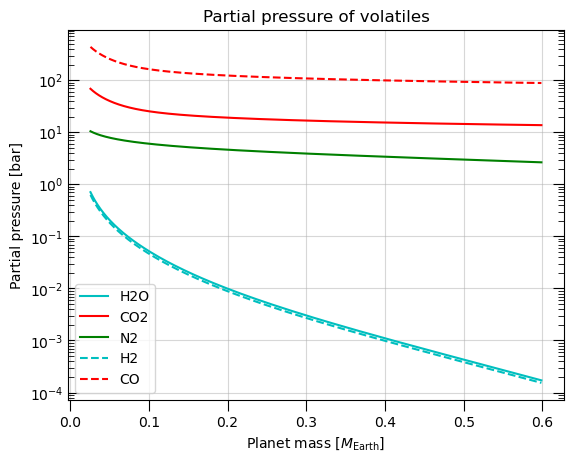

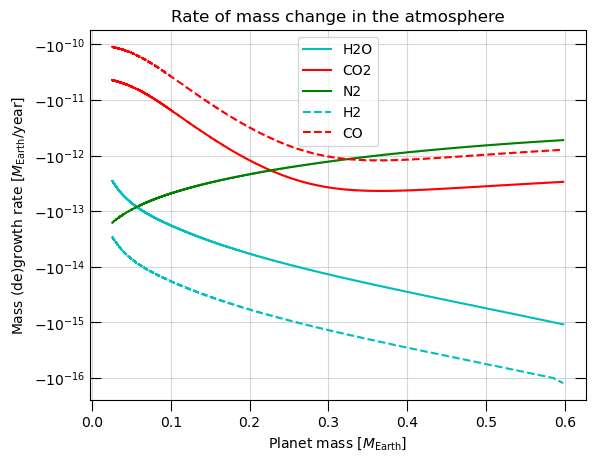

In [146]:
# Miatm vs time
# plt.figure()
# for i in irange:
#     plt.semilogy(timearray, Miatmtimearray[i]/earthmass, color=vcolors[i])
#     plt.title('Volatile inventory in the atmosphere')
#     plt.ylabel('Mass'+r'$[M_\mathrm{Earth}/\mathrm{year}]$')
#     plt.xlabel('Time [years]')
#     plt.ticklabel_format(style='sci', axis='x', scilimits=(0,3))
#     plt.grid(alpha=0.5)

# Miatm vs protomass
plt.figure()
for i in irange:
    plt.semilogy(protomasstimearray[longstartind:longstopind]/earthmass, Miatmtimearray[i][longstartind:longstopind]/earthmass, color=vcolors[i], label=gasvolatiles[i])
for i in range(len(extragasvolatiles)):
    plt.semilogy(protomasstimearray[longstartind:longstopind]/earthmass, Miatmextratimearray[i][longstartind:longstopind]/earthmass, '--', color=vcolors[i], label=extragasvolatiles[i])
plt.title('Volatile inventory in the atmosphere')
plt.ylabel('Volatile mass '+r'$[M_\mathrm{Earth}]$')
plt.xlabel('Planet mass '+r'$[M_\mathrm{Earth}]$')
plt.grid(alpha=0.5)
plt.legend()

# pi vs. protomass
pi_evo = np.array([GPatobar*psurf_evo[j]*molefraction(Miatmfulltimearray[:,j], amuifull) for j in range(len(timearray))]).transpose()
plt.figure()
for i in irange:
    plt.semilogy(protomasstimearray[longstartind:longstopind]/earthmass, pi_evo[i][longstartind:longstopind], '-', color=vcolors[i], label=fullgasvolatiles[i])
for i in range(len(extragasvolatiles)):
    plt.semilogy(protomasstimearray[longstartind:longstopind]/earthmass, pi_evo[len(volatiles)+i][longstartind:longstopind], '--',  color=vcolors[i], label=fullgasvolatiles[len(volatiles)+i])
plt.legend()
plt.title('Partial pressure of volatiles')
plt.ylabel('Partial pressure [bar]')
plt.xlabel('Planet mass '+r'$[M_\mathrm{Earth}]$')
plt.grid(alpha=0.5)
# plt.tick_params(axis='y', which='major', left=True, right=True, size=6, direction='in')
# plt.tick_params(axis='y', which='minor', left=True, right=True, size=4, direction='in')
plt.legend()

# dMiatm/dt vs. protomass
plt.figure()
sedratemin = []
for i in irange:
    sedrate = (delta(Miatmtimearray[i][longstartind:longstopind])/delta(timearray[longstartind:longstopind]))/earthmass
    posind = np.nonzero(sedrate>0)[0]
    negind = np.nonzero(sedrate<=0)[0]
    plt.plot(centeraveraging(protomasstimearray)[posind+longstartind-1]/earthmass, sedrate[posind],'-', color=vcolors[i], label=gasvolatiles[i])
    plt.plot(centeraveraging(protomasstimearray)[negind+longstartind-1]/earthmass, sedrate[negind],'-', color=vcolors[i])
    sedratemin += [np.min(np.abs(sedrate))] 
for i in range(len(extragasvolatiles)):
    sedrate = (delta(Miatmextratimearray[i][longstartind:longstopind])/delta(timearray[longstartind:longstopind]))/earthmass
    posind = np.nonzero(sedrate>0)[0]
    negind = np.nonzero(sedrate<0)[0]
    plt.plot(centeraveraging(protomasstimearray)[posind+longstartind-1]/earthmass, sedrate[posind],'--', color=vcolors[i], label=extragasvolatiles[i])
    plt.plot(centeraveraging(protomasstimearray)[negind+longstartind-1]/earthmass, sedrate[negind],'--', color=vcolors[i])
    sedratemin += [np.min(np.abs(sedrate))] 
plt.yscale('symlog', linthresh=10**(int(np.log10(np.min(sedratemin)))))
if (longstartind in negind):
    plt.gca().invert_yaxis()

plt.title('Rate of mass change in the atmosphere')
plt.ylabel('Mass (de)growth rate '+r'$[M_\mathrm{Earth}/\mathrm{year}]$')
plt.xlabel('Planet mass ' + r'$[M_\mathrm{Earth}$]')
plt.legend()
plt.grid(alpha=0.5)




In [147]:
# Compare dissolution to sedimentation rates

# DO THIS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

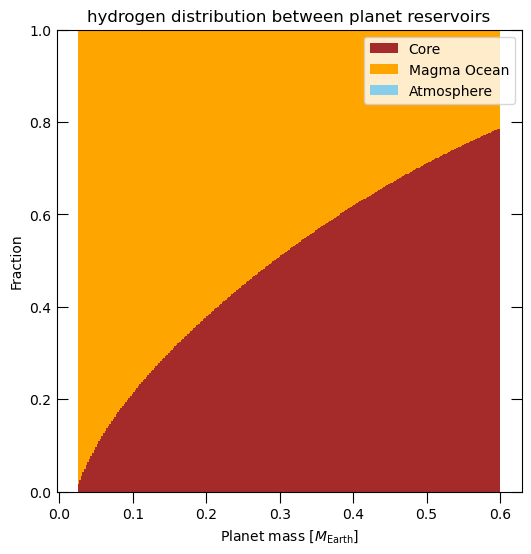

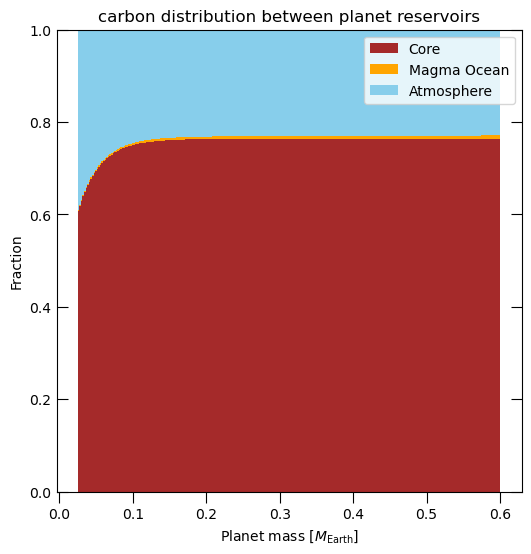

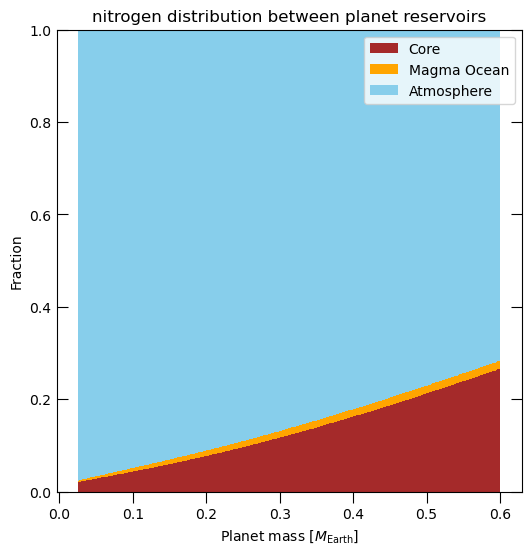

In [ ]:
# Volatile storage, where are they? 

npoints = (shortstopind%len(timeplotarray))-shortstartind # modulo operator bypasses problem where we've define stopind = -1 (final point)
protomasslin, protostep = np.linspace(protomasstimearray[longstartind], protomasstimearray[longstopind], npoints, retstep=True)

Miatmused = [Miatmsumtimearray, Miatmequivsumtimearray][1] # choose how to tally atmosphere mass. 0: naively count mass of species, 1: count mass of reduced species as if they were containing the extra oxygen atom. 
Miatmsuminterp = np.array([np.interp(protomasslin, protomasstimearray, Miatmused[i]) for i in irange])
Mimagmainterp = np.array([np.interp(protomasslin, protomasstimeplotarray, Mimagma[:, i]) for i in irange])
Micoreinterp = np.array([np.interp(protomasslin, protomasstimearray, Micoretimearray[i]) for i in irange])
Mitotinterp = Miatmsuminterp+Micoreinterp+Mimagmainterp # total volatile inventory

fiatminterp = Miatmsuminterp/Mitotinterp
fimagmainterp = Mimagmainterp/Mitotinterp
ficoreinterp = Micoreinterp/Mitotinterp

reservoircolors = ['brown', 'orange', 'skyblue']

for i in irange:
    plt.figure(figsize=(6,6))
    plt.bar(protomasslin/earthmass, ficoreinterp[i], width=protostep/earthmass, color=reservoircolors[0], label='Core')
    plt.bar(protomasslin/earthmass, fimagmainterp[i], width=protostep/earthmass, bottom=ficoreinterp[i], color=reservoircolors[1], label='Magma Ocean')
    plt.bar(protomasslin/earthmass, fiatminterp[i], width=protostep/earthmass, bottom=ficoreinterp[i]+fimagmainterp[i], color=reservoircolors[2], label='Atmosphere')
    plt.title(volatiles[i]+' distribution between planet reservoirs')
    plt.ylabel('Fraction')
    plt.xlabel('Planet mass '+r'$[M_\mathrm{Earth}]$')
    plt.gca().set_ylim(0, 1)
    plt.legend()


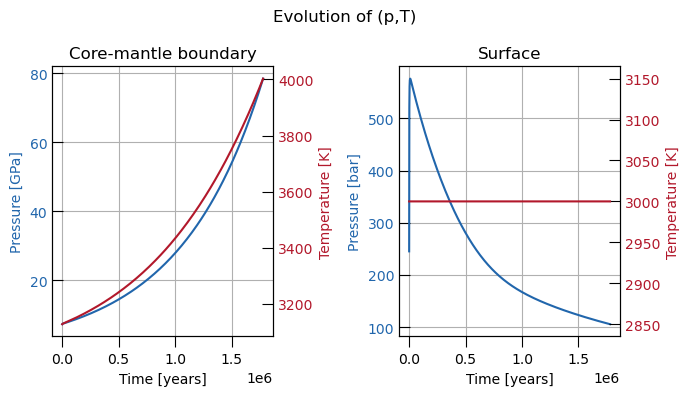

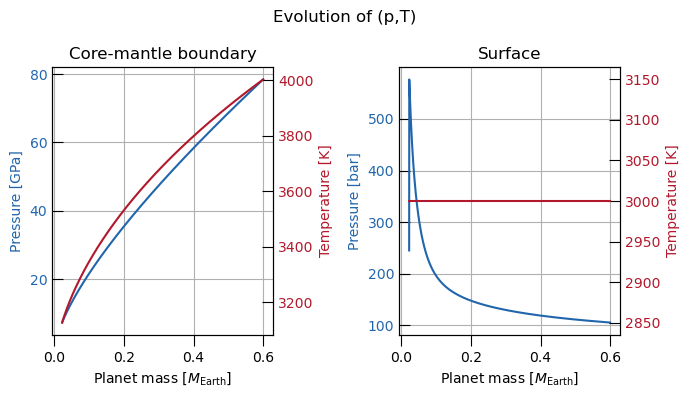

In [149]:
# evolution of p, T over time.
fig, (ax1, ax2) = plt.subplots(1,2, figsize=((7,4)))
fig.suptitle('Evolution of (p,T)')
colors = ['#2166ac', '#b2182b']

ax1.set_title('Core-mantle boundary')
ax1.set_xlabel('Time [years]')
ax1.set_ylabel('Pressure [GPa]', color=colors[0])
ax1.plot(timearray, cmbcondtimearray[1,:], color=colors[0])
ax1.tick_params(axis='y', labelcolor=colors[0])
ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,3))

ax3 = ax1.twinx()  # shared x-axis
ax3.set_ylabel('Temperature [K]', color=colors[1])
ax3.plot(timearray, cmbcondtimearray[2,:], color=colors[1])
ax3.tick_params(axis='y', labelcolor=colors[1])

ax2.set_title('Surface')
ax2.set_xlabel('Time [years]')
ax2.set_ylabel('Pressure [bar]', color=colors[0])
ax2.plot(timearray, surfcondtimearray[1,:]*GPatobar, color=colors[0])
ax2.tick_params(axis='y', labelcolor=colors[0])
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,3))

ax4 = ax2.twinx()  # shared x-axis
ax4.set_ylabel('Temperature [K]', color=colors[1])
ax4.plot(timearray, surfcondtimearray[2,:], color=colors[1])
ax4.tick_params(axis='y', labelcolor=colors[1])

ax1.locator_params(axis='both', nbins=6)  # set number of tick-marks
ax2.locator_params(axis='both', nbins=6)
ax1.grid(True)  # plot a grid
ax2.grid(True)
fig.tight_layout()  # otherwise the right y-label is slightly clipped


# EVOLUTION OF (p, T) w.r.t PROTOMASS
# evolution of p, T over time. DO SAME PLOT BUT WITH X AXIS = PROTOMASSTIMEARRAY
fig, (ax1, ax2) = plt.subplots(1,2, figsize=((7,4)))
fig.suptitle('Evolution of (p,T)')
colors = ['#2166ac', '#b2182b']

ax1.set_title('Core-mantle boundary')
ax1.set_xlabel('Planet mass '+r'$[M_\mathrm{Earth}]$')
ax1.set_ylabel('Pressure [GPa]', color=colors[0])
ax1.plot(protomasstimearray/earthmass, cmbcondtimearray[1,:], color=colors[0])
ax1.tick_params(axis='y', labelcolor=colors[0])

ax3 = ax1.twinx()  # shared x-axis
ax3.set_ylabel('Temperature [K]', color=colors[1])
ax3.plot(protomasstimearray/earthmass, cmbcondtimearray[2,:], color=colors[1])
ax3.tick_params(axis='y', labelcolor=colors[1])

ax2.set_title('Surface')
ax2.set_xlabel('Planet mass '+r'$[M_\mathrm{Earth}]$')
ax2.set_ylabel('Pressure [bar]', color=colors[0])
ax2.plot(protomasstimearray/earthmass, surfcondtimearray[1,:]*GPatobar, color=colors[0])
ax2.tick_params(axis='y', labelcolor=colors[0])

ax4 = ax2.twinx()  # shared x-axis
ax4.set_ylabel('Temperature [K]', color=colors[1])
ax4.plot(protomasstimearray/earthmass, surfcondtimearray[2,:], color=colors[1])
ax4.tick_params(axis='y', labelcolor=colors[1])

ax1.locator_params(axis='both', nbins=6)  # set number of tick-marks
ax2.locator_params(axis='both', nbins=6)
ax1.grid(True)  # plot a grid
ax2.grid(True)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

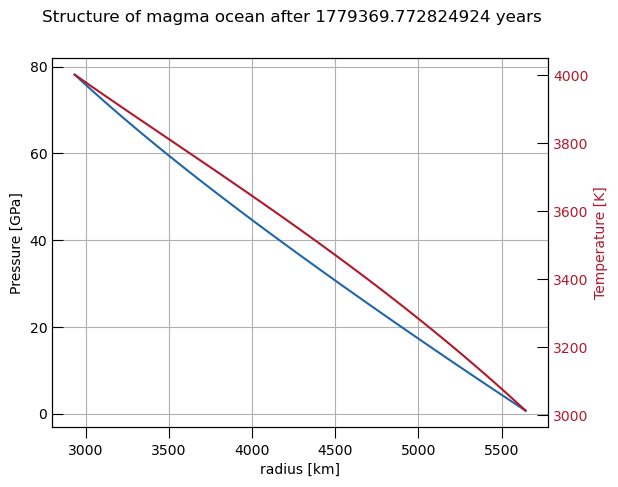

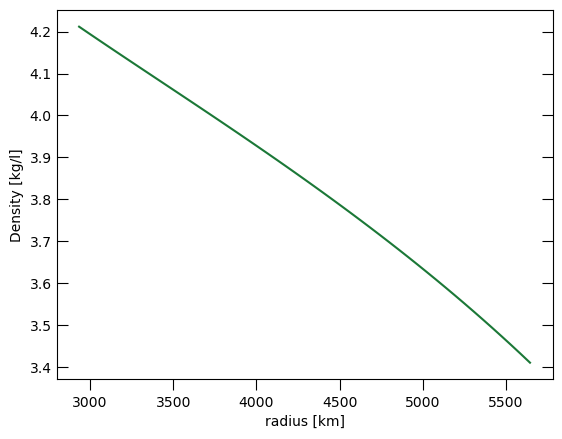

In [168]:
fig, ax1 = plt.subplots(1,1)
fig.suptitle('Structure of magma ocean after '+str(timearray[-1]) +
                         ' years')
colors = ['#1b7837', '#762a83', '#2166ac', '#b2182b']
ax1.set_ylabel('Pressure [GPa]')
ax1.set_xlabel('radius [km]')
ax1.plot(rkfromfile[-1], pressurefromfile[-1], color=colors[2])

ax2 = ax1.twinx()
ax2.plot(rkfromfile[-1], temperaturefromfile[-1], color=colors[3])
ax2.set_ylabel('Temperature [K]', color=colors[3])
ax2.tick_params(axis='y', labelcolor=colors[3])
ax1.locator_params(axis='both', nbins=6)  # set number of tick-marks
ax1.grid(True)  # plot a grid

plt.figure()
plt.ylabel('Density [kg/l]')
plt.xlabel('radius [km]')
plt.plot(rkfromfile[-1], densityfromfile[-1], color=colors[0])


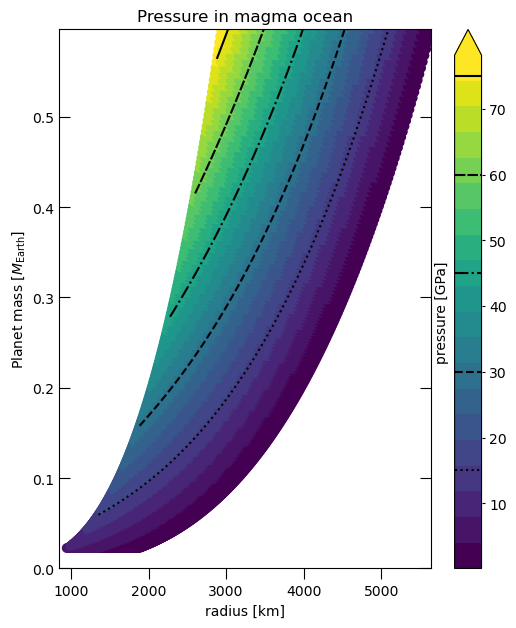

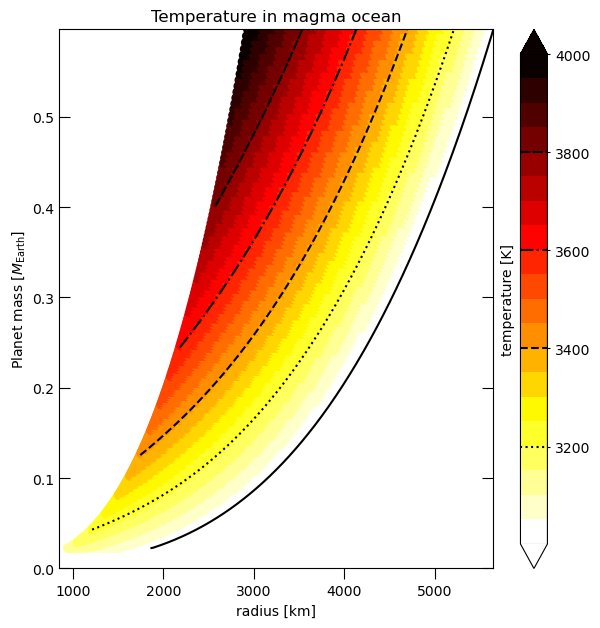

In [184]:
linestylelist=['-', ':', '--','-.', (0, (5,1)), '-']

massplotmatrix = np.tile(protomasstimeplotarray/earthmass, (len(rkfromfile[0]), 1)).transpose()

pressurefig = plt.figure(figsize=(6,7))
plt.title('Pressure in magma ocean')
cmap = plt.get_cmap('viridis', 20)
y = pressurefromfile
CS = plt.scatter(rkfromfile, massplotmatrix, c=y, cmap=cmap, norm=mplcolors.Normalize(vmin=y.min(), vmax=y.max()))
colorax = plt.gca()
colorax.set_xlabel('radius [km]')
colorax.set_ylabel('Planet mass '+r'$[M_\mathrm{Earth}]$')
cbar = pressurefig.colorbar(CS, label='pressure [GPa]', extend='max')
cbar.ax.yaxis.set_label_position("left")
contour = colorax.contour(rkfromfile, massplotmatrix, y, levels=5, colors='k', linewidths=1.5, linestyles=linestylelist)
for j in range(len(contour.levels)):
    cbar.ax.axhline(contour.levels[j], color='k', linestyle=linestylelist[j%len(linestylelist)])
plt.gca().set_ylim(bottom=0)
plt.gca().set_xlim(left=rkfromfile[0,0]*0.9)
cbar.ax.tick_params(axis='y', which='both', direction='out', size=2)

temperaturefig = plt.figure(figsize=(7,7))
plt.title('Temperature in magma ocean')
cmap = plt.get_cmap('hot_r', 20)
y = temperaturefromfile
CS = plt.scatter(rkfromfile, massplotmatrix, c=y, cmap=cmap, norm=mplcolors.Normalize(vmin=y.min(), vmax=y.max()))
plt.plot(rkfromfile[:,-1], protomasstimeplotarray/earthmass, color='k', linewidth=1.5)
colorax = plt.gca()
colorax.set_xlabel('radius [km]')
colorax.set_ylabel('Planet mass '+r'$[M_\mathrm{Earth}]$')
cbar = temperaturefig.colorbar(CS, label='temperature [K]', extend='both')
cbar.ax.yaxis.set_label_position("left")
contour = colorax.contour(rkfromfile, massplotmatrix, y, levels=4, colors='k', linewidths=1.5, linestyles=linestylelist)
for j in range(len(contour.levels)):
    cbar.ax.axhline(contour.levels[j], color='k', linestyle=linestylelist[j%len(linestylelist)])
plt.gca().set_ylim(bottom=0)
plt.gca().set_xlim(left=rkfromfile[0,0]*0.9)
cbar.ax.tick_params(axis='y', which='both', direction='out', size=2)


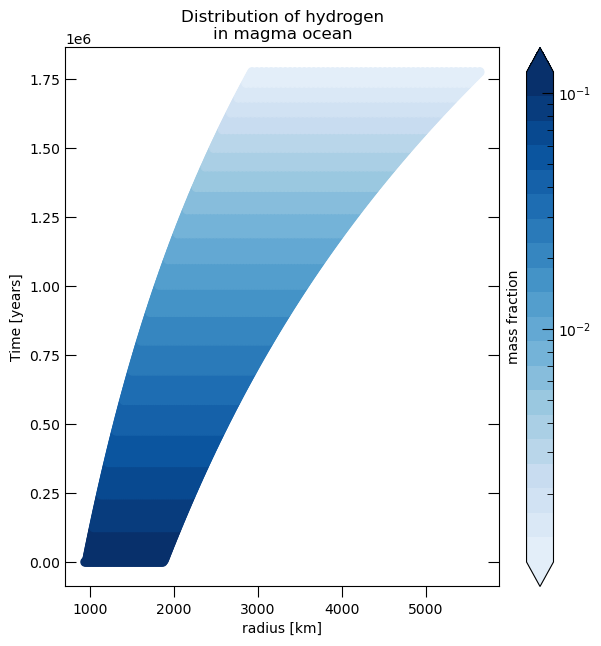

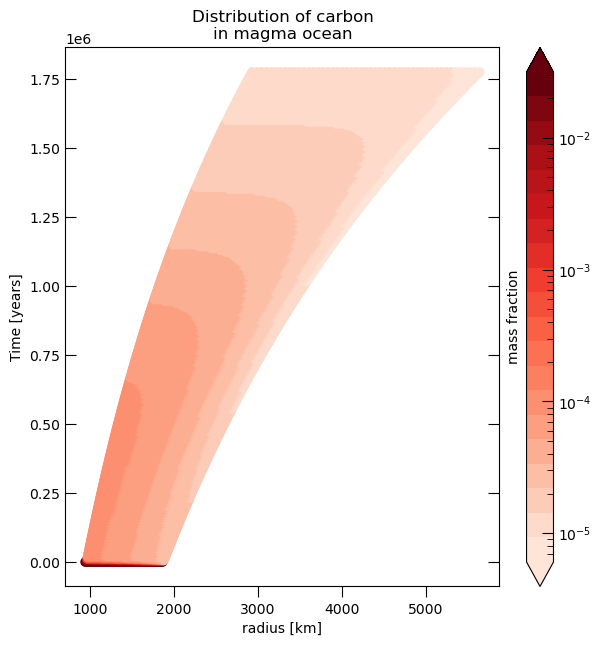

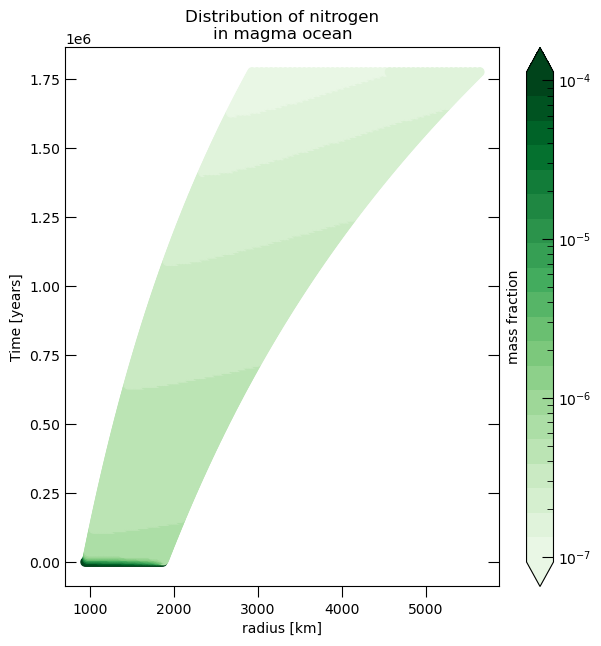

In [152]:
volatilecolorstyles = np.array(['Blues','Reds','Greens'])

timeplotmatrix = np.tile(timeplotarray, (len(rkfromfile[0]), 1)).transpose()
for i in irange:
    colorfig = plt.figure(figsize=(7,7))
    cmap = plt.get_cmap(volatilecolorstyles[i])
    cmap = cmap.from_list(volatilecolorstyles[i], cmap.__call__(np.linspace(0.1, 1, 20)), 20)
    y = Mvolfromfile[:,i]/Mtotfromfile
    CS = plt.scatter(rkfromfile, timeplotmatrix, c=y, cmap=cmap, norm=mplcolors.LogNorm(vmin=y.min(), vmax=y.max()))
    plt.title('Distribution of '+volatiles[i]+'\n'+'in magma ocean')
    colorax = plt.gca()
    colorax.set_xlabel('radius [km]')
    colorax.set_ylabel('Time [years]')
    colorax.ticklabel_format(style='sci', axis='y', scilimits=(0,3))
    cbar = colorfig.colorbar(CS, label='mass fraction', extend='both')
    cbar.ax.yaxis.set_label_position("left")
    # contourlevels = np.logspace(np.log10(y.min()), np.log10(y.max()), 21)
    # contour = colorax.contour(rkfromfile, timeplotmatrix, y, levels=contourlevels, colors='k', linewidths=1)
    # cbar.add_lines(levels=contour.levels, colors=['k' for _ in contour.levels], linewidths=[1 for _ in contour.levels])



    

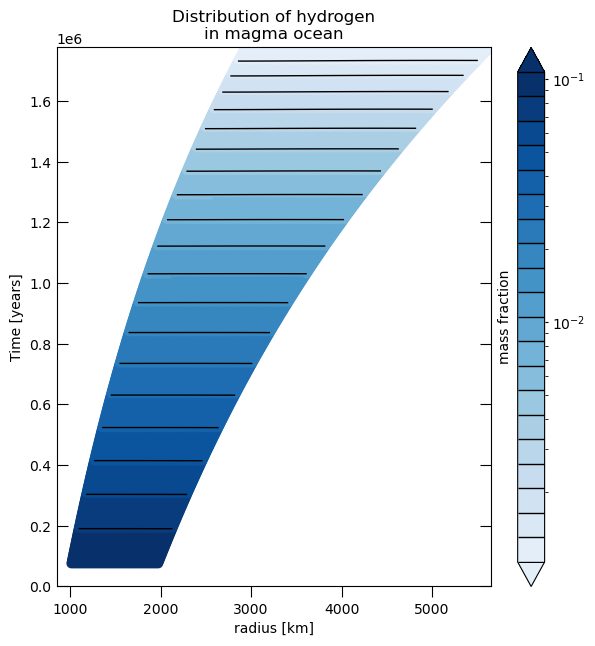

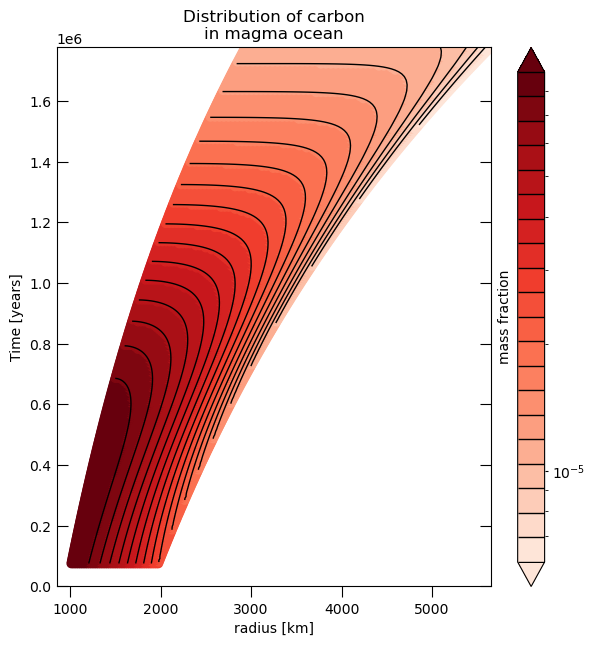

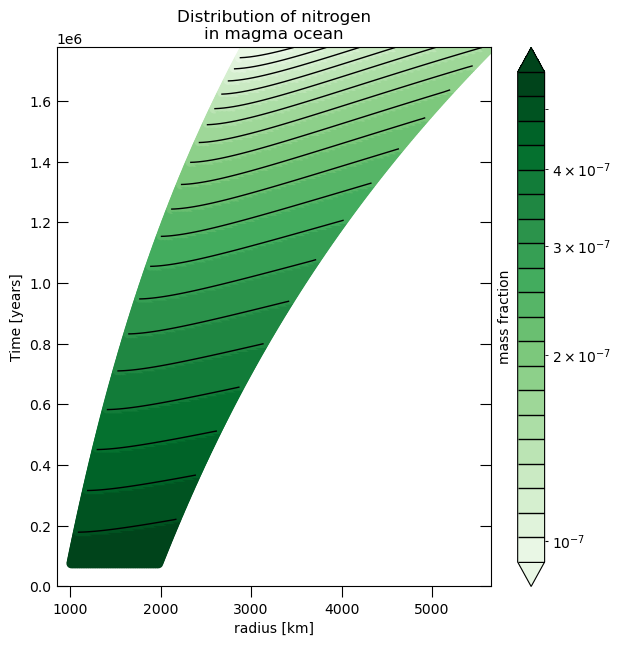

In [183]:
timeplotmatrix = np.tile(timeplotarray, (len(rkfromfile[0]), 1)).transpose()
# cutofftime = timearray[np.nonzero(Micoretimearray[0]>0)[0][0]] # option 0, plot from first starting to sediment
cutoffind = shortstartind # option 1, start plot manually from chosen time
for i in irange:
    colorfig = plt.figure(figsize=(7,7))
    cmap = plt.get_cmap(volatilecolorstyles[i])
    cmap = cmap.from_list(volatilecolorstyles[i], cmap.__call__(np.linspace(0.1, 1, 20)), 20)
    y = Mvolfromfile[:,i]/Mtotfromfile
    CS = plt.scatter(rkfromfile[cutoffind:], timeplotmatrix[cutoffind:], c=y[cutoffind:], cmap=cmap, norm=mplcolors.LogNorm(vmin=y[cutoffind:].min(), vmax=y[cutoffind:].max()))
    plt.title('Distribution of '+volatiles[i]+'\n'+'in magma ocean')
    colorax = plt.gca()
    colorax.set_xlabel('radius [km]')
    colorax.set_ylabel('Time [years]')
    colorax.ticklabel_format(style='sci', axis='y', scilimits=(0,3))
    cbar = colorfig.colorbar(CS, label='mass fraction', extend='both')
    cbar.ax.yaxis.set_label_position("left")
    contourlevels = np.logspace(np.log10(y[cutoffind:].min()), np.log10(y[cutoffind:].max()), 21)
    contour = colorax.contour(rkfromfile[cutoffind:], timeplotmatrix[cutoffind:], y[cutoffind:], levels=contourlevels, colors='k', linewidths=1)
    cbar.add_lines(levels=contour.levels, colors=['k' for _ in contour.levels], linewidths=[1 for _ in contour.levels])
    plt.gca().set_ylim(bottom=0)
    plt.gca().set_xlim(left=rkfromfile[0,0]*0.9)
    cbar.ax.tick_params(axis='y', which='both', direction='out', size=2)


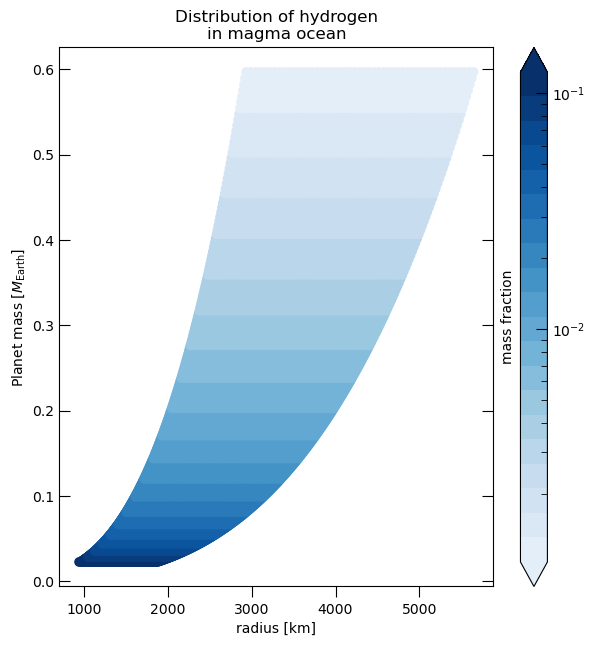

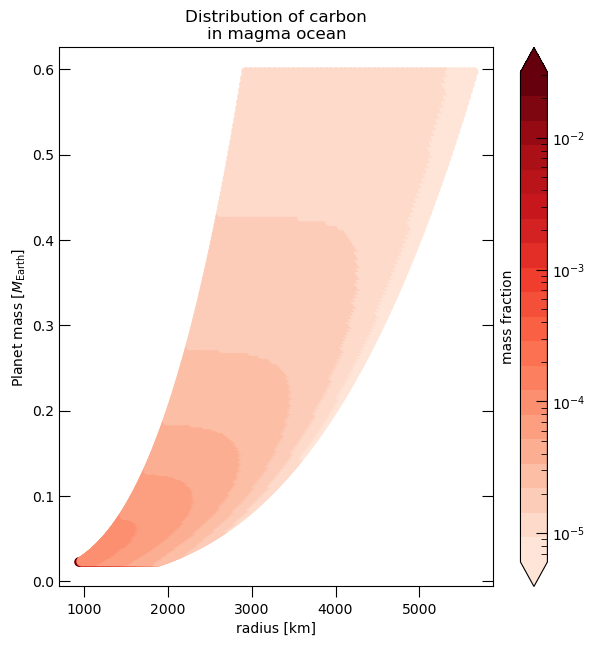

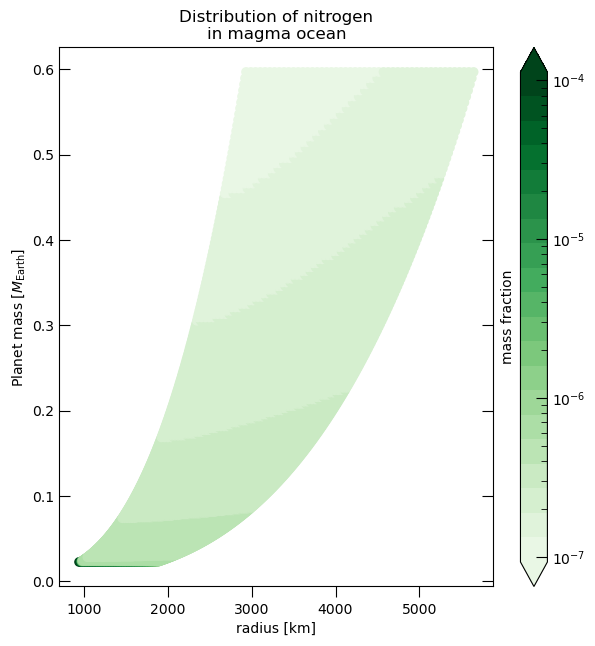

In [154]:
# mass radius distribution color plot
protomassplotmatrix = np.tile(protomasstimeplotarray, (len(rkfromfile[0]), 1)).transpose()
cutoffmass = protomasstimearray[np.nonzero(Micoretimearray[0]>0)[0][0]] # ensure that you've started accreting
cutoffind = np.nonzero(cutoffmass<=protomasstimeplotarray)[0][0]

for i in irange:
    colorfig = plt.figure(figsize=(7,7))
    cmap = plt.get_cmap(volatilecolorstyles[i])
    cmap = cmap.from_list(volatilecolorstyles[i], cmap.__call__(np.linspace(0.1, 1, 20)), 20)
    y = Mvolfromfile[:,i]/Mtotfromfile
    CS = plt.scatter(rkfromfile[cutoffind:], protomassplotmatrix[cutoffind:]/earthmass, c=y[cutoffind:], cmap=cmap, norm=mplcolors.LogNorm(vmin=y[cutoffind:].min(), vmax=y[cutoffind:].max()))
    plt.title('Distribution of '+volatiles[i]+'\n'+'in magma ocean')
    colorax = plt.gca()
    colorax.set_xlabel('radius [km]')
    colorax.set_ylabel('Planet mass '+r'$[M_\mathrm{Earth}]$')
    cbar = colorfig.colorbar(CS, label='mass fraction', extend='both')
    cbar.ax.yaxis.set_label_position("left")
    # contourlevels = np.logspace(np.log10(y[cutoffind:].min()), np.log10(y[cutoffind:].max()), 21)
    # contour = colorax.contour(rkfromfile[cutoffind:], protomassplotmatrix[cutoffind:]/earthmass, y[cutoffind:], levels=contourlevels, colors='k', linewidths=1)
    # cbar.add_lines(levels=contour.levels, colors=['k' for _ in contour.levels], linewidths=[1 for _ in contour.levels])



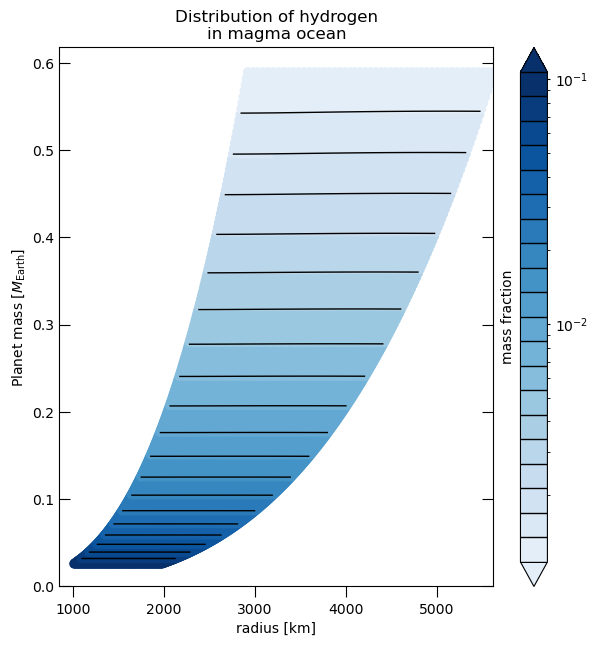

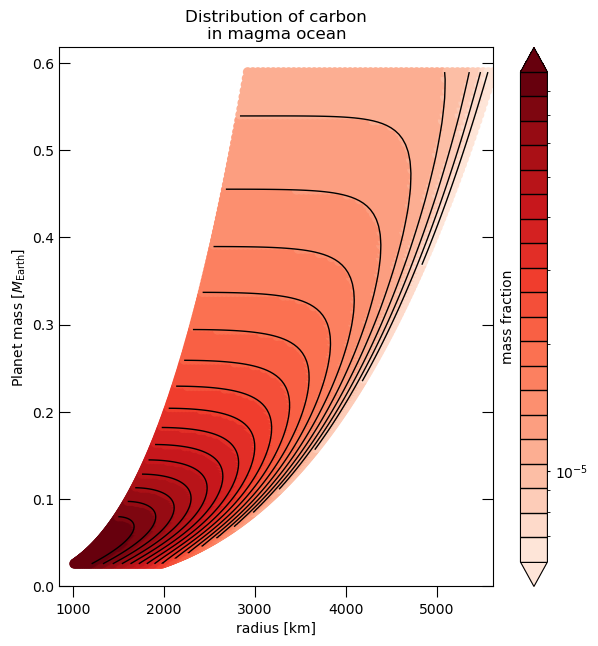

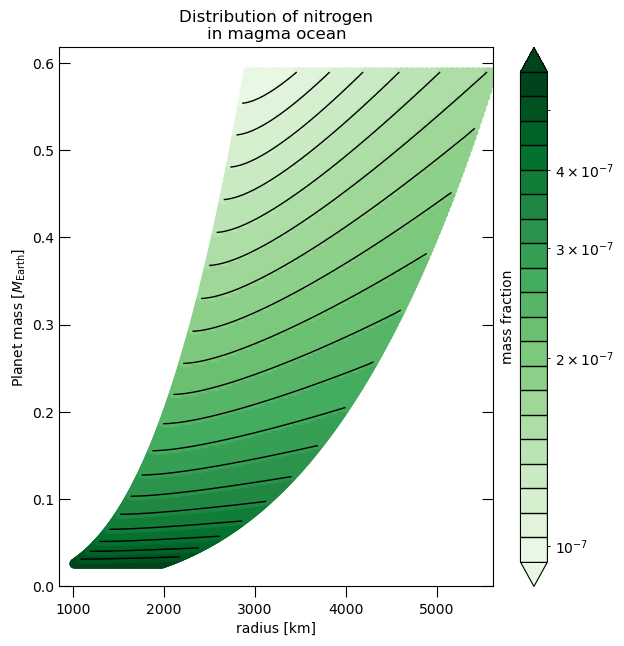

In [185]:
# cutoff mass radius distribution color plot
protomassplotmatrix = np.tile(protomasstimeplotarray, (len(rkfromfile[0]), 1)).transpose()
startcut = 0.05*earthmass # CHOICE, lowest mass plotted
stopcut = 0.6*earthmass # CHOICE, highest mass plotted
startind = np.nonzero(startcut<=protomasstimeplotarray)[0][0]
if stopcut<protomasstimeplotarray[-1]:
    stopind = np.nonzero(stopcut<=protomasstimeplotarray)[0][0]
else:
    stopind = len(protomasstimeplotarray)-1

# Or use same cut-off choice as other plots
startind = shortstartind
stopind = shortstopind

for i in irange:
    colorfig = plt.figure(figsize=(7,7))
    cmap = plt.get_cmap(volatilecolorstyles[i])
    cmap = cmap.from_list(volatilecolorstyles[i], cmap.__call__(np.linspace(0.1, 1, 20)), 20)
    y = Mvolfromfile[:,i]/Mtotfromfile
    CS = plt.scatter(rkfromfile[startind:stopind], protomassplotmatrix[startind:stopind]/earthmass, c=y[startind:stopind], cmap=cmap, norm=mplcolors.LogNorm(vmin=y[startind:stopind].min(), vmax=y[startind:stopind].max()))
    plt.title('Distribution of '+volatiles[i]+'\n'+'in magma ocean')
    colorax = plt.gca()
    colorax.set_ylim(bottom=0)
    colorax.set_xlabel('radius [km]')
    colorax.set_ylabel('Planet mass '+r'$[M_\mathrm{Earth}]$')
    cbar = colorfig.colorbar(CS, label='mass fraction', extend='both')
    cbar.ax.yaxis.set_label_position("left")
    contourlevels = np.logspace(np.log10(y[startind:stopind].min()), np.log10(y[startind:stopind].max()), 21)
    contour = colorax.contour(rkfromfile[startind:stopind], protomassplotmatrix[startind:stopind]/earthmass, y[startind:stopind], levels=contourlevels, colors='k', linewidths=1)
    cbar.add_lines(levels=contour.levels, colors=['k' for _ in contour.levels], linewidths=[1 for _ in contour.levels])
    plt.gca().set_ylim(bottom=0)
    plt.gca().set_xlim(left=rkfromfile[0,0]*0.9)
    cbar.ax.tick_params(axis='y', which='both', direction='out', size=2)



Text(0.5, 1.0, 'Partition coefficient of volatiles \n between metal and silicate melt')

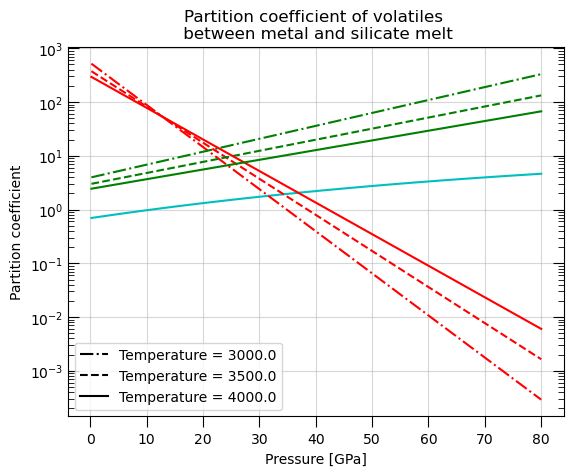

In [156]:
# Partition coefficient as function of p,T (and hydrogen fraction at final time step)

# Carbon partition coefficient. Parametrization from Fischer2020. Pressure, temperature in GPa, K units.
def PCfunc(p, T, deltaIW=deltaIWmagmaocean, Xoxygen=0, Xsulfur=XS, NBOperT=NBOperT, microprobe=False):
    if cappedtemperature:
        np.where(temperature>5500, 5500, temperature) # approximate limit of parametrization 
    if microprobe: # derived from microprobe analysis in Fischer2020
            log10PC = 1.81+2470/T-227*p/T+9.7 * \
            np.log10(1-Xsulfur)-30.6*np.log10(1-Xoxygen) - \
            0.123*NBOperT-0.211*deltaIW
    else: # derived from nanoSIMS analysis in Fischer2020
        log10PC = 1.49+3000/T-235*p/T+9.6 * \
            np.log10(1-Xsulfur)-19.5*np.log10(1-Xoxygen) - \
            0.118*NBOperT-0.238*deltaIW
    return 10**log10PC


# Nitrogen partition function. Parametrization from Grewal2019. Pressure, temperature in GPa, K units.
def PNfunc(p, T, XFeO=XFeO, Xsulfur=XS, Xsilicon=0, NBOperT=NBOperT):
    if cappedtemperature:
        np.where(temperature>2200, 2200, np.where(temperature<1500, 1500, temperature)) # approximate limit of parametrization 
    a, b, c, d, e, f, g, h = -1415.40, 5816.24, 166.14, 343.44, -38.36, 139.52, 0.82, 1.13
    # calculate log10 of the partition coefficient for nitrogen.
    lnPN = a+b/T+c*p/T+d*np.log(100*(1-Xsulfur))+e*np.log(100*(1-Xsulfur))**2+f*np.log(100*(1-Xsilicon))+g*NBOperT+h*np.log(100*XFeO)
    return np.exp(lnPN)  # return the partition coefficient


# Water partition function. Parametrization from Luo2024. Function of water concentration in metal melt.
def PH2Ofunc(p, XH2Omet):
    XH2Omet = np.where(XH2Omet>1e-8, XH2Omet, 1e-8) # PREVENTS log10(0). 
    log10PH2O = 1.26-0.34 * \
        np.log10(XH2Omet*100)+0.08*np.log10(XH2Omet*100)**2-4007/(1+np.exp((p+616)/80.6))
    return 10**log10PH2O


# mass of water in metal droplets/mass of metal droplets, (torn long-edge @ page 8 of block C for derivation) 
def watermetalfraction(PH2O, MH2O, Msil, Mmet):
    return PH2O*MH2O/(PH2O*Mmet+Msil)


# calculates PH2O then watermetalfraction, then back to PH2O using a starting guess for the mass fraction of water in the metal droplets.
def iterativePH2O(p, MH2O, Msil, Mmet, CH2Ometguess=0.01, iterations=10):
    for j in range(iterations):
        PH2Oguess = PH2Ofunc(p, CH2Ometguess)
        CH2Ometguess = watermetalfraction(PH2Oguess, MH2O, Msil, Mmet)
    return PH2Oguess, CH2Ometguess


with open('continuefile', 'rb') as f:
        simulatedyears, protomass0, pebblerate0, mc0, Msil, Mmet, rsurf, rk, rcore, psurf, Tsurf, pressure, temperature, density, D, CH2Omet, Pvol, Mvol, Micore0, Miatm, Miatmextra0, fO2surf0, eigval0, eigvec0, Vinv0 = pickle.load(f)
        
plin = np.linspace(0.2, 80, number_of_layers)
Tlin = np.linspace(3000, 4000, 3)
temperaturelinestyles = ['-.','--','-']

PH2Olin, CH2Olin = iterativePH2O(plin, Mvol[0], Msil, Mmet)


plt.figure()
plt.semilogy(plin, PH2Olin, color=vcolors[0])
for Tind in range(len(Tlin)):
    PClin = PCfunc(plin, Tlin[Tind])
    PNlin = PNfunc(plin, Tlin[Tind])
    plt.semilogy(plin, PClin, color=vcolors[1], linestyle=temperaturelinestyles[Tind])
    plt.semilogy(plin, PNlin, color=vcolors[2], linestyle=temperaturelinestyles[Tind])
    plt.semilogy(0, 0, label='Temperature = '+str(Tlin[Tind]), color='k', linestyle=temperaturelinestyles[Tind])
plt.legend()
plt.grid(alpha=0.5)
plt.xlabel('Pressure [GPa]')
plt.ylabel('Partition coefficient')
plt.title('Partition coefficient of volatiles \n between metal and silicate melt')

(3, 282)
(3, 282)


Text(0.5, 1.0, 'Effective partition coefficient')

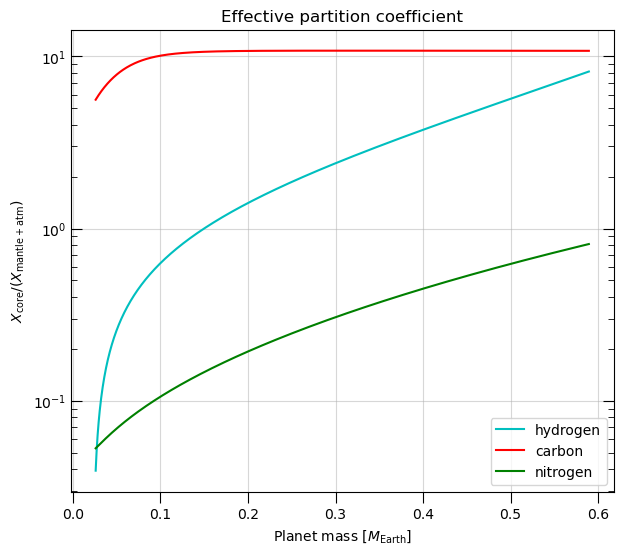

In [186]:
# Effective partition coefficient w.r.t planet mass
Xicoretimearray = Micoretimearray/Mctimearray
Miatmplusmantle = Mimagma.transpose()+np.array([np.interp(timeplotarray, timearray, M) for M in Miatmsumtimearray])
Xiatmplusmantle = Miatmplusmantle/np.sum(Mtotfromfile, axis=1)

# interpolate Xicore to more sparse time array
Xicoretimeplotarray = np.array([np.interp(timeplotarray, timearray, Xi) for Xi in Xicoretimearray])

print((Mimagma.transpose()).shape)
print(Xicoretimeplotarray.shape)

Peff = Xicoretimeplotarray/Xiatmplusmantle # effective partition coefficient (being in the atmosphere counts as being in the mantle for the sake of this definition)
# nconvolve = 5 # smooth the plot (by plotting a sliding average of the points)
# Peffconvolve = np.array([np.convolve(P, np.ones(nconvolve)/nconvolve, mode='valid') for P in Peff])

plt.figure(figsize=(7,6))
for i in irange:
    plt.semilogy(protomasstimeplotarray[shortstartind:shortstopind]/earthmass, Peff[i][shortstartind:shortstopind], '-', color=vcolors[i], label=volatiles[i])
    # plt.semilogy(protomasstimeplotarray/earthmass, Peff[i], '.', markersize=1, color=vcolors[i])
    # plt.semilogy(protomasstimeplotarray[nconvolve//2:-nconvolve//2+1]/earthmass, Peffconvolve[i], color=vcolors[i], label=volatiles[i])
plt.legend()
plt.grid(alpha=0.5)
plt.xlabel('Planet mass '+r'$[M_\mathrm{Earth}]$')
plt.ylabel(r'$X_{\mathrm{core}}/(X_{\mathrm{mantle+atm}})$')
plt.title('Effective partition coefficient')

In [158]:
def Kifunc(Matm, fO2surf, rsurf, protomass, pebblerate, H2Oindex=0, meltindex=2, Miatmfull=None, species='CO2'): # choice of melt from which experimental K for CO2 is taken
    psurf, Tsurf = pTsurf(rsurf, Matm=Matm, protomass=protomass, pebblerate=pebblerate, a=a, Miatmfull=Miatmfull, species=species)
    pinkbar = psurf*GPatokbar
    pinbar = psurf*GPatobar
    
    if H2Oindex==0 and cappedtemperature:
        Tsurf = np.where(Tsurf>1500, 1500, Tsurf) # approximate limit of Burnham1994. Slight extrapolation
    
    KH2Ointermediate = 0.2 # Stolper1982, fig. 4. approximate equilibrium constant for intermediate water dissolution step H2O(g) -> H2O(m)
    KH2Oburnham = KH2Ointermediate*1/(np.exp(5.00+np.log(pinbar)*(4.481e-8*Tsurf**2-1.51e-4*Tsurf-1.137)+np.log(pinbar)**2*(1.831e-8*Tsurf**2-4.882e-5*Tsurf+4.656e-2)+7.80e-3*np.log(pinbar)**3-5.012e-4*np.log(pinbar)**4+Tsurf*(4.754e-3-1.621e-6*Tsurf))) # Burnham 1994, eq. 7. Taken to power -1 because their K is defined for the inverse reaction. PLACEHOLDER INCORRECT. IS ONLY EQ. CONST FOR THE H2O(melt)+O->2 OH(melt) REACTION!
    KH2Ostolper = KH2Ointermediate*np.exp(-3+pinkbar/10) # Stolper1982, fig. 4 and eq. 8. Product of K1 and K2. Slopes up one log unit after 10 kbar.
    KH2O = np.array([KH2Oburnham, KH2Ostolper])[H2Oindex] # index choice
    
    KCO2withNepheline = 1/np.exp(12.5+5.5*pinkbar/30) # Spera1980, fig. 1. Minus sign since we want the reverse equilibrium constant
    KCO2withOlivineMelilite = 1/np.exp(13+5*pinkbar/30) # Spera1980, fig. 3. -||-
    KCO2fromAnders = 4.4*1e-12*1e5 # AnatomyII, 1e5 to convert from per Pascal to per bar.
    KCO2 = np.array([KCO2withNepheline, KCO2withOlivineMelilite, KCO2fromAnders])[meltindex] # index choice
    
    R = 8.31446261815324 # J/(mol*K), universal gas constant    
    if cappedtemperature:
        Tsurf = np.where(Tsurf>1300+273, 1300+273, Tsurf) # approximate limit of Bernadou2021
    KN2chem = (np.exp(-(183733+172*Tsurf-5*pinbar)/(R*Tsurf)))**2*fO2surf**(-3/2) # Bernadou2021, eq. 14 & Table 6. fO2 dependence from eq. 18. Squaring because we compose our equivalent reaction with whole number volatile-bearing products and reactants. 
    if meltindex==2: # Follow AnatomyII eq. 12. for nitrogen dissolution iff we followed eq. 11 for carbon dissolution
        KN2phys = 6.11*1e-13*1e5 # AnatomyII, 1e5 to convert from per Pascal to per bar
    else:
        KN2phys = np.exp(-(29344+121*Tsurf+4*pinbar)/(R*Tsurf)) # Bernadou2021, eq. 13 & Table 6.

    return np.array([[KH2O, 0], [KCO2, 0], [KN2chem, KN2phys]])

def molefraction(w, amu): # calculates the mole fraction of each species using the weight fraction (or mass) and atomic mass of each species
    return np.array([(w[i]/amu[i])/(np.sum(w/amu)) for i in range(len(w))])

def pTsurf(rsurf, Matm=Matmguess, pebblerate=pebblerate0, protomass=protomass, gamma=envgamma, a=a0, Lstar=Lsun, species='CO2', Miatmfull=None):
    gsurf = G*protomass/rsurf**2
    if constanttemperature:
        Tsurf = Tconst 
        ppho = 2/3*gsurf/opacitypho*GPaconversion
        psurf = ppho + gsurf*Matm/(4*pi*rsurf**2)*GPaconversion # thin outgassed atmosphere approximation, penv approx = 0
    else:
        Ltot = pebblerate*G*protomass/rsurf
        penv, Tenv = pTenvbot(rsurf, pebblerate, protomass, gamma, a, Lstar)
        ppho = penv+2/3*gsurf/opacitypho*GPaconversion
        psurf = ppho + gsurf*Matm/(4*pi*rsurf**2)*GPaconversion # thin outgassed atmosphere approximation
        Tatmbot = Tatmintegral(psurf, ppho, Tenv, species, Miatmfull)
        Tsurf = (Tatmbot**4+Ltot/(4*pi*rsurf**2*sigmaBoltzmann))**(1/4)
    return psurf, Tsurf


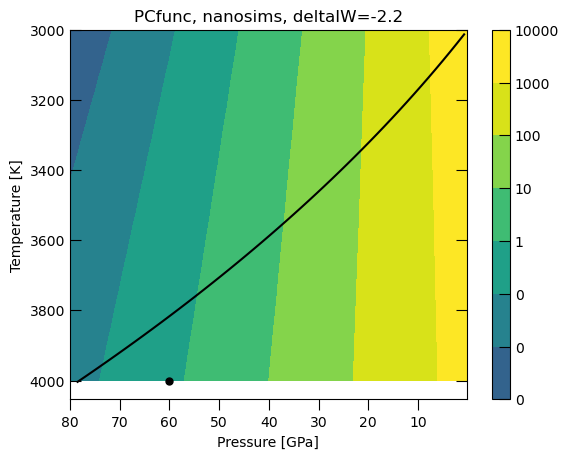

In [159]:
# TESTS 2025-05-13, after development meeting

plin = np.linspace(0.2, 80, number_of_layers)
Tlin = np.linspace(3000, 4000, number_of_layers)
X, Y = np.meshgrid(plin, Tlin)

microprobe='nanosims'
microprobebool=microprobe=='microprobe'
deltaIWchoice = -2.2
Z = PCfunc(X, Y, microprobe=microprobebool, deltaIW=deltaIWchoice, NBOperT=2.6, Xoxygen=0.1)

fO2fig = plt.figure()
CS = plt.contourf(X,Y,Z,10,norm=mplcolors.LogNorm(vmin=1e-5, vmax=1e3))
cbar = fO2fig.colorbar(CS)
# invert axes so that going to the left or going down on the plot corresponds to further into the magma ocean
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.title('PCfunc, '+str(microprobe)+', deltaIW='+str(deltaIWchoice)) # PLACEHOLDER, specify what deltaIW is in the figure title
plt.xlabel('Pressure [GPa]')
plt.ylabel('Temperature [K]')
plt.plot(pressure, temperature, color='k')

plt.plot(60, 4000, '.', markersize=10, color='k')


(0.1, 0.6)

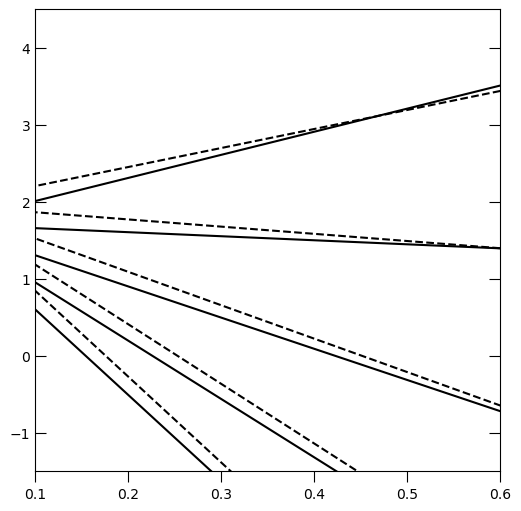

In [160]:
plt.figure(figsize=(6,6))
ptester = np.array([0, 15, 30, 45, 60])
Ttester = np.linspace(1500, 10000)
for p in ptester:
    plt.plot(1000/Ttester, np.log10(PCfunc(p, Ttester, microprobe=True, deltaIW=deltaIWchoice, NBOperT=2.6)),label='p = '+str(p)+' GPa', color='k', linestyle='--')
    plt.plot(1000/Ttester, np.log10(PCfunc(p, Ttester, microprobe=False, deltaIW=deltaIWchoice, NBOperT=2.6)),label='p = '+str(p)+' GPa', color='k', linestyle='-')

plt.gca().set_ylim((-1.5), (4.5))
plt.gca().set_xlim(0.1,0.6)

Text(0.5, 1.0, 'Recreating Bernadou2021 Fig. 3')

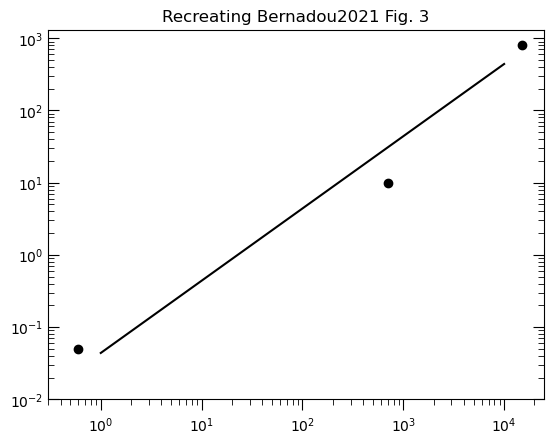

In [161]:
Miatmfull = np.concatenate((Miatmtimearray[:,-1], Miatmextratimearray[:,-1]))
Matm = np.sum(Miatmfull) 
KN2 = Kifunc(Matm, fO2surf0, rsurf, protomass0, pebblerate0, meltindex=0)[2]
pN2bar = np.linspace(1, 10000)
XN2 = KN2[1]*pN2bar+(KN2[0]*pN2bar)**(1/2)
plt.figure()
plt.loglog(pN2bar, XN2*1e6, color='k')
plt.loglog([0.6, 700, 15000], [0.05, 10, 800],'o',color='k')
plt.gca().axis(xmin=3e-1, ymin=1e-2)
plt.title('Recreating Bernadou2021 Fig. 3')

In [162]:
Ki = Kifunc(Matm, fO2surf0, rsurf, protomass0, pebblerate0, meltindex=2)
KCO2 = Ki[1,0]
print('Comparison to AnatomyII eq. 11 and 12: \nCO2: '+str(KCO2*1/100000)+', N2: '+str(KN2[1]*1/100000))

Comparison to AnatomyII eq. 11 and 12: 
CO2: 4.400000000000001e-12, N2: 4.397580728754258e-13


Final atmosphere speciation as a function of deltaIW at the end of accretion: 

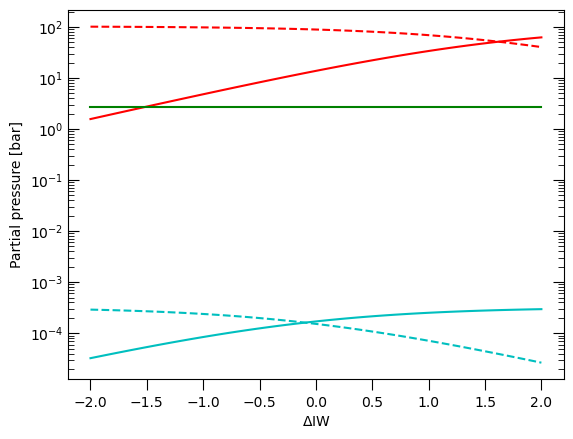

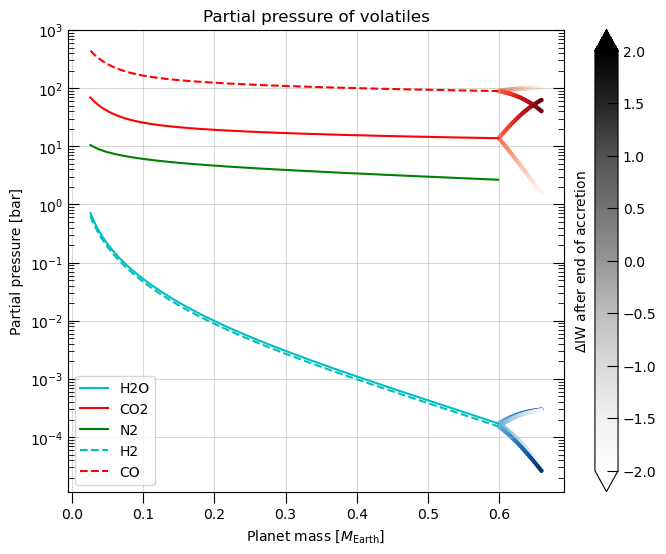

In [163]:
def IWfO2func(p, T): # oxygen fugacity of the IW-buffer Fe + O <-> FeO. Hirschmann2021. Valid for T>1000 K and P between 1e-4 and 100 GPa. "It extrapolates smoothly to higher temperature, though not calibrated above 3000 K." 
    def m(m0, m1, m2, m3, m4):
        return m0+m1*p+m2*p**2+m3*p**3+m4*p**(1/2)
    # parameters for fit to fcc (gamma-Fe) and bcc (alpha-Fe) allotropes of iron
    a = m(6.844864, 1.175691e-1, 1.143873e-3, 0, 0)
    b = m(5.791364e-4, -2.891434e-4, -2.737171e-7, 0, 0)
    c = m(-7.971469e-5, 3.198005e-5, 0, 1.059554e-10, 2.014461e-7)
    d = m(-2.769002e4, 5.285977e2, -2.919275, 0, 0)
    # parameters for fit to hcp (epsilon-Fe) allotrope of iron
    e = m(8.463095, -3.000307e-3, 7.213445e-5, 0, 0)
    f = m(1.148738e-3, -9.352312e-5, 5.161592e-7, 0, 0)
    g = m(-7.448624e-4, -6.329325e-6, 0, -1.407339e-10, 1.830014e-4)
    h = m(-2.782082e4, 5.285977e2, -8.473231e-1, 0, 0)

    hcpdomain = p>(-18.64 + 0.04359*T - 5.069e-6*T**2) # check for what p, T the iron is hcp
    def fit(P1, P2, P3, P4): # fitting function using either (a,b,c,d) or (e,f,g,h)
        return P1+P2*T+P3*T*np.log(T)+P4/T
    if cappedtemperature:
        np.where(temperature>3500, 3500, np.where(temperature>1000, temperature, 1000)) # K, approximate temperature limit for Hirschmann2021 parametrization
    log10fO2 = np.where(hcpdomain, fit(e,f,g,h), fit(a,b,c,d))
    return 10**log10fO2

def fO2func(p, T, deltaIW=deltaIW, cappedfraction=False): # oxygen fugacity 
    fO2para = IWfO2func(p, T)*10**deltaIW # fO2 as defined by Hirschmann2021 parametrization
    if cappedfraction:
        fO2max = p*cappedfraction # fO2 cannot exceed some fraction of the total pressure
        return np.where(fO2max<fO2para, fO2max, fO2para)
    else: 
        return fO2para

def gasgasfunc(Miatm, Miatmextra, amuifull, fO2, Tsurf, splitbool=True):
    xi0full = molefraction(np.concatenate((Miatm, Miatmextra)), amuifull) # initial mole fraction of each species
    xi0, xi0extra = np.split(xi0full, [len(Miatm)]) # split mole fraction into [H2O, CO2, N2] and [H2, CO]
    xwat = xi0[0]+xi0extra[0] # mole fraction of all "water"-bearing species
    xcar = xi0[1]+xi0extra[1] # mole fraction of all carbon-bearing species

    Kwat, Kcar = Kigasgas(Tsurf) # equilibrium constants for gas-gas reactions
    xH2O = xwat/(1+1/(Kwat*fO2)**(1/2))
    xCO2 = xcar/(1+1/(Kcar*fO2**(1/2)))
    xiextra = np.array([xwat-xH2O, xcar-xCO2])
    xN2 = xi0[2] 
    xi = np.array([xH2O, xCO2, xN2])
    xifull = np.concatenate((xi, xiextra))

    wifull = weightfraction(xifull, amuifull)
    Matm = Miatm[2]/wifull[2] # since N2 mass doesn't change set the total mass from the N2 weight fraction 
    Miatmfull = Matm*wifull
    # Miatmfull[2] = Miatm[2] # directly write the initial nitrogen mass
    if splitbool:
        Miatmeq, Miatmextraeq = np.split(Miatmfull, [len(Miatm)])
        oxygenmass = np.sum(Miatm-Miatmeq)+np.sum(Miatmextra-Miatmextraeq)
        print('gasgasfunc: Miatm,eq/Miatm0: '+str(Miatmeq/Miatm))
        return Miatmeq, Miatmextraeq, oxygenmass
    else:
        oxygenmass = np.sum(Miatm)+np.sum(Miatmextra)-np.sum(Miatmfull)
        return Miatmfull, xifull, wifull, oxygenmass

def Kigasgas(Tsurf): # equilibrium coefficients for gas gas specation. Direction: reduced + 1/2 O2 --> oxidized
    R = 8.31446261815324 # J/(mol*K), universal gas constant
    RT = R*Tsurf
    # Ortenzi2020. coefficients for delta G for oxygenic formation of CO, CO2 and H2O
    aH2O, bH2O, cH2O = -483095.0, 25.3687, 21.9563
    aCO, bCO, cCO = -214104.0, 25.2183, -262.1545 # units J, J/T, J/T
    aCO2, bCO2, cCO2 = -392647.0, 4.5855, -16.9762

    def fit(a, b, c):
        return a + b*Tsurf*np.log10(Tsurf) + c*Tsurf
    Gwat = fit(aH2O, bH2O, cH2O)
    Gcar = fit(aCO2, bCO2, cCO2)-1/2*fit(aCO, bCO, cCO)

    Kwat = np.exp(-Gwat/RT)
    Kcar = np.exp(-Gcar/RT)
    return Kwat, Kcar

# final masses in the atmosphere
Miatmfinal = Miatmtimearray[:, -1]
Miatmextrafinal = Miatmextratimearray[:, -1]

deltaIWlin = np.linspace(-2, 2, 50)
deltaIWplottingpoints = np.arange(deltaIWlin.min(), deltaIWlin.max(), 1)
xiatmspeciation = np.array([gasgasfunc(Miatmfinal, Miatmextrafinal, amuifull, fO2func(psurf_evo[-1], Tsurf_evo[-1], IW), Tsurf_evo[-1], splitbool=False)[1] for IW in deltaIWlin])
piatmspeciation = xiatmspeciation*psurf_evo[-1]*GPatobar # [bar]

# plt.figure()
for i in irange:
    plt.semilogy(deltaIWlin, piatmspeciation[:,i],color=vcolors[i])
for j in range(len(extragasvolatiles)):
    plt.semilogy(deltaIWlin, piatmspeciation[:,j+len(gasvolatiles)], '--', color=vcolors[j])
plt.xlabel(r"$\Delta$"+"IW")
plt.ylabel('Partial pressure [bar]')

# PLOT pi vs. protomass AGAIN. BUT WITH SPECIATION POINTS
pi_evo = np.array([GPatobar*psurf_evo[j]*molefraction(Miatmfulltimearray[:,j], amuifull) for j in range(len(timearray))]).transpose()
scattercmapname = 'magma'

pifig = plt.figure(figsize=(8,6))
plt.title('Partial pressure of volatiles')
plt.ylabel('Partial pressure [bar]')
plt.xlabel('Planet mass '+r'$[M_\mathrm{Earth}]$')
plt.grid(alpha=0.5)
ax1 = plt.gca()

for i in irange:
    ax1.semilogy(protomasstimearray[longstartind:longstopind]/earthmass, pi_evo[i][longstartind:longstopind], '-', color=vcolors[i], label=fullgasvolatiles[i])
    # Plot final speciation options
    if not (i==2): # nitrogen doesn't speciate
        ax1.scatter(protomasstimearray[longstopind]*(1+np.abs(deltaIWlin)/20)/earthmass, piatmspeciation[:,i], c=deltaIWlin, cmap=volatilecolorstyles[i], vmin=deltaIWlin.min(), vmax=deltaIWlin.max(), s=5)

for i in range(len(extragasvolatiles)):
    ax1.semilogy(protomasstimearray[longstartind:longstopind]/earthmass, pi_evo[len(volatiles)+i][longstartind:longstopind], '--',  color=vcolors[i], label=fullgasvolatiles[len(volatiles)+i])
    # Plot final speciation options
    if not (i==2): # nitrogen doesn't speciate
        SC = ax1.scatter(protomasstimearray[longstopind]*(1+np.abs(deltaIWlin)/20)/earthmass, piatmspeciation[:,i+len(gasvolatiles)], c=deltaIWlin, cmap=volatilecolorstyles[i], vmin=deltaIWlin.min(), vmax=deltaIWlin.max(), s=5)
SCdummy = ax1.scatter(protomasstimearray[longstopind]*(1+np.abs(deltaIWlin)/20)/earthmass, piatmspeciation[:,i+len(gasvolatiles)], c=deltaIWlin, cmap='Greys', vmin=deltaIWlin.min(), vmax=deltaIWlin.max(), s=0)

scattercbar = pifig.colorbar(SCdummy, label="$\Delta$IW after end of accretion", extend='both')
scattercbar.ax.yaxis.set_label_position("left")
ax1.legend()

/tmp/ipykernel_2693107/4139335626.py:36: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  scattercbar = pifig.colorbar(SC, label="$\Delta$IW", extend='both')


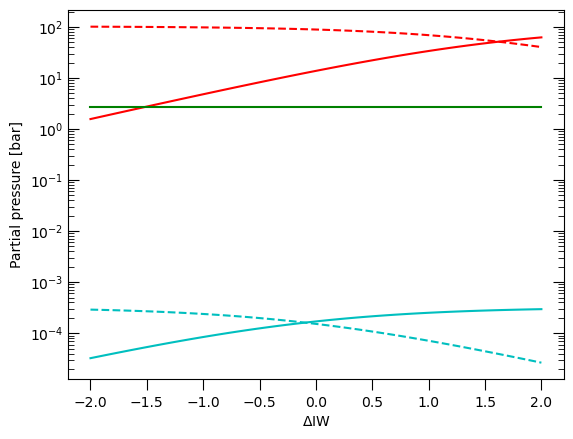

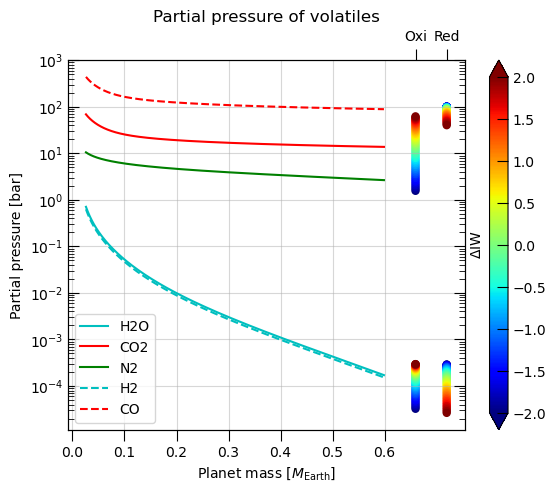

In [164]:
plt.figure()
for i in irange:
    plt.semilogy(deltaIWlin, piatmspeciation[:,i],color=vcolors[i])
for j in range(len(extragasvolatiles)):
    plt.semilogy(deltaIWlin, piatmspeciation[:,j+len(gasvolatiles)], '--', color=vcolors[j])
plt.xlabel(r"$\Delta$"+"IW")
plt.ylabel('Partial pressure [bar]')


# PLOT pi vs. protomass AGAIN. BUT WITH SPECIATION POINTS
pi_evo = np.array([GPatobar*psurf_evo[j]*molefraction(Miatmfulltimearray[:,j], amuifull) for j in range(len(timearray))]).transpose()
scattercmapname = 'jet'
# scattercmap = plt.get_cmap(scattercmapname)
# scattercmap = cmap.from_list(scattercmapname, scattercmap.__call__(np.linspace(0.2, 1, 100)), 100)


pifig = plt.figure()
plt.title('Partial pressure of volatiles')
plt.ylabel('Partial pressure [bar]')
plt.xlabel('Planet mass '+r'$[M_\mathrm{Earth}]$')
plt.grid(alpha=0.5)
ax1 = plt.gca()
axtwiny = ax1.twiny()

for i in irange:
    ax1.semilogy(protomasstimearray[longstartind:longstopind]/earthmass, pi_evo[i][longstartind:longstopind], '-', color=vcolors[i], label=fullgasvolatiles[i])
    # Plot final speciation options
    if not (i==2): # nitrogen doesn't speciate
        ax1.scatter(np.repeat(protomasstimearray[longstopind]*1.1/earthmass, len(piatmspeciation[:,i])), piatmspeciation[:,i], c=deltaIWlin, cmap=scattercmapname, vmin=deltaIWlin.min(), vmax=deltaIWlin.max(), s=25)

for i in range(len(extragasvolatiles)):
    ax1.semilogy(protomasstimearray[longstartind:longstopind]/earthmass, pi_evo[len(volatiles)+i][longstartind:longstopind], '--',  color=vcolors[i], label=fullgasvolatiles[len(volatiles)+i])
    # Plot final speciation options
    if not (i==2): # nitrogen doesn't speciate
        SC = ax1.scatter(np.repeat(protomasstimearray[longstopind]*1.2/earthmass, len(piatmspeciation[:,i])), piatmspeciation[:,i+len(gasvolatiles)], c=deltaIWlin, cmap=scattercmapname, vmin=deltaIWlin.min(), vmax=deltaIWlin.max(), s=25)
scattercbar = pifig.colorbar(SC, label="$\Delta$IW", extend='both')
scattercbar.ax.yaxis.set_label_position("left")
ax1.legend()
ax1.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

axtwiny.set_xlim(ax1.get_xlim())
axtwiny.set_xticks(protomasstimearray[longstopind]/earthmass*np.array([1.1, 1.2]), ['Oxi', 'Red'])